**1. Import CDN Dataset**

In [1]:
#Download dataset from: https://docs.google.com/spreadsheets/d/14TMBl6tfV2BZ1QQZCs0HeasngNLmnUUn/edit?usp=sharing&ouid=100794820815526789197&rtpof=true&sd=true
!gdown --id 14TMBl6tfV2BZ1QQZCs0HeasngNLmnUUn

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=14TMBl6tfV2BZ1QQZCs0HeasngNLmnUUn
To: /content/data.xlsx
100% 17.4M/17.4M [00:00<00:00, 64.2MB/s]


**2. Import Library**

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import ipywidgets as widgets

# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn import preprocessing, svm
import tensorflow as tf 
import sys
import missingno as mno
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

**3. Explore Data**

In [4]:
data_xls = pd.read_excel('data.xlsx', 'cdn_customer_qoe_anon', dtype=str, index_col=None)
data_xls.to_csv('data.csv', encoding='utf-8', index=False)

In the dataset, there are two column, "Start Time" and "End Time" contain datetime data. Parse this two column into datetime format for Time Series Analysis and check the amount of data on in the sequence.

In [5]:
df = pd.read_csv("data.csv", parse_dates=["Start Time", "End Time"])
df.head()

Column1          Start Time  Playtime  Effective Playtime  Interruptions  \
0        0 2022-07-12 00:00:14        11                  10              0   
1        1 2022-07-12 00:00:38        73                  72              0   
2        2 2022-07-12 00:02:02        21                  20              0   
3        3 2022-07-12 00:02:24         1                   0              0   
4        4 2022-07-12 00:02:25         1                   0              0   

   Join Time  Buffer Ratio CDN Node Host Connection Type      Device  \
0      0.879           0.0           NaN    Ethernet-100  Android TV   
1      1.170           0.0           NaN          WiFi-5  Android TV   
2      1.133           0.0           NaN          WiFi-5  Android TV   
3      0.000           0.0           NaN          WiFi-5  Android TV   
4      0.000           0.0           NaN          WiFi-5  Android TV   

  Device Type          Browser  Browser Version       OS  OS Version  \
0          TV  Android Browser  Android Browser  Android  Android 10   
1          TV  Android Browser  Android Browser  Android  Android 10   
2          TV  Android Browser  Android Browser  Android  Android 10   
3          TV  Android Browser  Android Browser  Android  Android 10   
4          TV  Android Browser  Android Browser  Android  Android 10   

                              Device ID Happiness Value  Happiness Score  \
0  186ba46d-4400-39df-8693-1ca9d25caf48   Smile (7-8.5)            7.393   
1  35f76782-6990-3fa2-bdb8-0f35a2c5569c  Happy (8.5-10)            9.399   
2  16846b9d-4bd6-3b16-a464-cb99378f3249   Neutral (5-7)            6.999   
3  16846b9d-4bd6-3b16-a464-cb99378f3249     Angry (0-3)            0.000   
4  16846b9d-4bd6-3b16-a464-cb99378f3249     Angry (0-3)            0.000   

   Playback Stalls  Startup Error (Count)  Latency            End Time  \
0              0.0                      0    19504 2022-10-04 00:00:26   
1              0.0                      0    19033 2022-10-04 00:01:52   
2              0.0                      0    19071 2022-10-04 00:02:24   
3              0.0                      0        0 2022-10-04 00:02:26   
4              0.0                      0        0 2022-10-04 00:02:28   

  Crash Status End of Playback Status  User_ID_N  Title_N  Program_N  \
0          NaN                On Stop        564      784          0   
1          NaN                On Stop        480        1          0   
2          NaN                On Stop        346      786          0   
3          NaN                On Stop        346      997          0   
4          NaN                On Stop        346      997          0   

   Device_Vendor_N  Device_Model_N  Content_TV_Show_N  Country_N  City_N  \
0               16              64               2672          3     263   
1               13              63               2672          3      76   
2               13              63               2672          3      76   
3               13              63               2672          3      76   
4               13              63               2672          3      76   

   Region_N  
0         0  
1         0  
2         0  
3         0  
4         0

In [ ]:
df.tail()

Column1          Start Time  Playtime  Effective Playtime  \
102251   102251 2022-07-25 23:06:05     15282                   0   
102252   102252 2022-07-25 22:55:39     16582               16581   
102253   102253 2022-07-25 23:09:33     21166                   0   
102254   102254 2022-07-25 11:47:37     65122               65115   
102255   102255 2022-07-25 14:07:08     75837               75717   

        Interruptions  Join Time  Buffer Ratio CDN Node Host Connection Type  \
102251              0      0.000         0.000           NaN          Mobile   
102252              0      0.990         0.000      11377663          WiFi-5   
102253              0      0.000         0.000           NaN          WiFi-5   
102254              2      6.103         0.001           NaN            None   
102255              0    120.000         0.000           NaN          WiFi-5   

               Device Device Type          Browser   Browser Version       OS  \
102251         iPhone  SmartPhone    Mobile Safari     Mobile Safari      iOS   
102252     Android TV          TV  Android Browser   Android Browser  Android   
102253        Android  STBAndroid  Android Browser   Android Browser  Android   
102254  PC( Windows )          PC           Chrome  Chrome 106.0.0.0  Windows   
102255        Android  STBAndroid  Android Browser   Android Browser  Android   

          OS Version                             Device ID Happiness Value  \
102251  iOS iOS:15.2  341C9AAD-8C51-4892-B3A8-E83EFE85439E     Angry (0-3)   
102252    Android 10  68c8ec91-d840-3939-be6f-b47410fc40c2  Happy (8.5-10)   
102253    Android 10  5b63edc5-6b14-3d17-b2b3-654b438d14cb     Angry (0-3)   
102254    Windows 10  bc64afea-dafa-4d58-bdd2-60ac8de742c2   Smile (7-8.5)   
102255    Android 10  a6d4fc0c-c548-490f-a5aa-d9de96cce74f     Angry (0-3)   

        Happiness Score  Playback Stalls  Startup Error (Count)  Latency  \
102251            0.000              0.0                      0        0   
102252            9.998              0.0                      0    18191   
102253            0.000              0.0                      0        0   
102254            7.465              0.0                      0    27550   
102255            0.000              0.0                      1    36285   

                  End Time Crash Status End of Playback Status  User_ID_N  \
102251 2022-10-18 03:20:47          NaN                On Stop        570   
102252 2022-10-18 03:32:02          NaN                On Stop        475   
102253 2022-10-18 05:02:21          NaN                On Stop        249   
102254 2022-10-18 05:53:00          NaN                On Stop        622   
102255 2022-10-18 11:11:06          NaN                On Stop        101   

        Title_N  Program_N  Device_Vendor_N  Device_Model_N  \
102251     1504          0                2             153   
102252     1014          0               13              63   
102253     1076          0               16              41   
102254     1437          0                8             158   
102255      902          0               13              15   

        Content_TV_Show_N  Country_N  City_N  Region_N  
102251               2434          3     367         0  
102252               2672          3      39         0  
102253               2672          3      56         0  
102254                694          3      56         0  
102255               2672          3     263         0

The dataset consist of 102256 row

Show Minimum and Maximum time in Column Start Time

In [ ]:
df["Start Time"].min(), df["Start Time"].max()

(Timestamp('2022-07-12 00:00:14'), Timestamp('2022-07-25 23:59:56'))

Show Minimum and Maximum time in Column End Time

In [ ]:
df["End Time"].min(), df["End Time"].max()

(Timestamp('2022-10-04 00:00:26'), Timestamp('2022-10-18 11:11:06'))

Check Shape of data

In [ ]:
df.shape

(102256, 33)

From shape of data, it can be seen there are 102256 series on 33 variable

**Show Correlation Matrix**

<ipython-input-10-4721ba411dd2>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



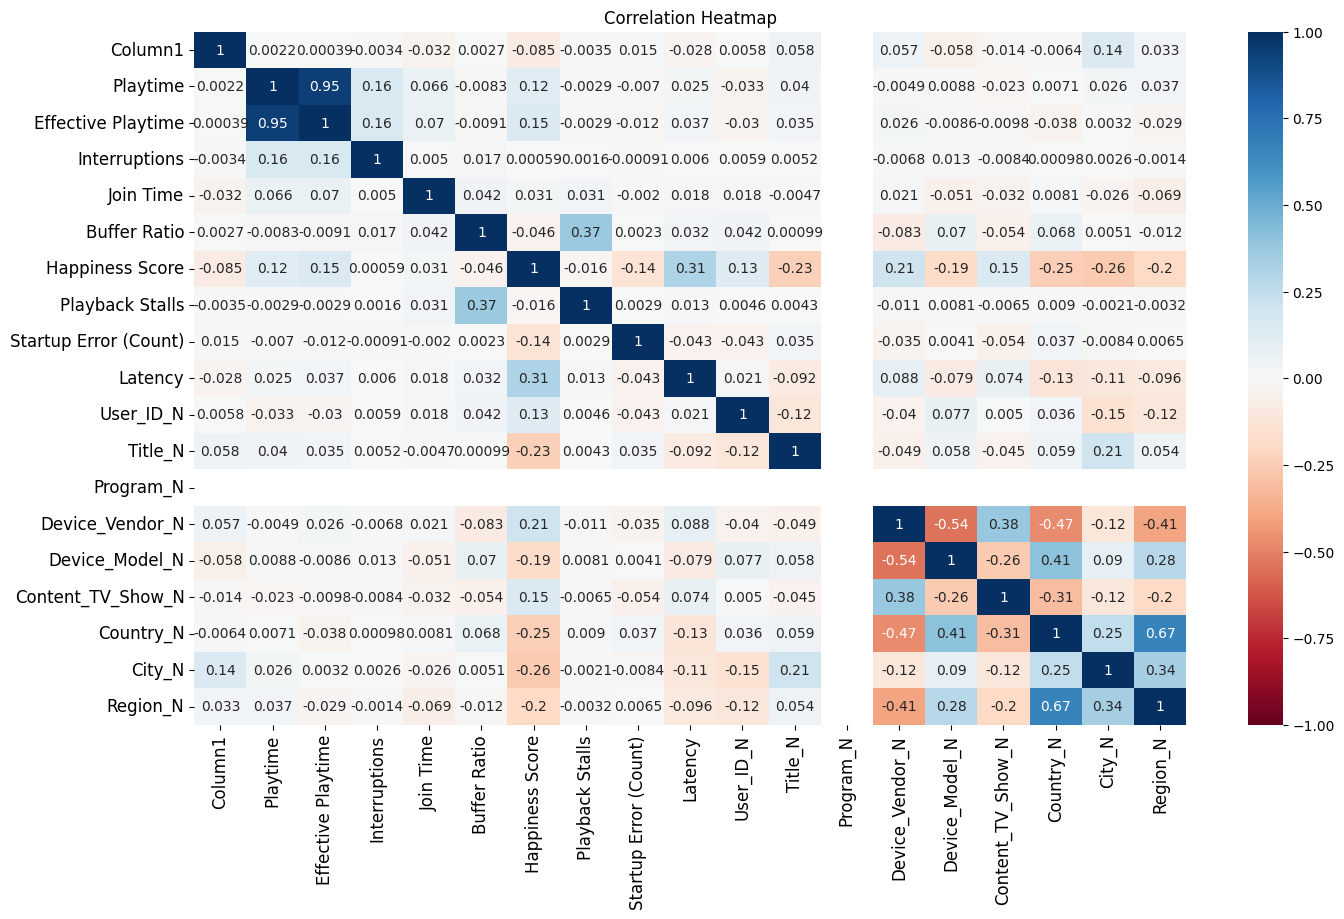

In [ ]:
plt.figure(figsize = (16, 9))
s = sns.heatmap(df.corr(),
                annot = True,
                cmap = 'RdBu',
                vmin = -1,
                vmax = 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

From the image it can be seen that Column Playtime and Effective Playtime have high correlation and we can say this 2 columns is similar. 

We choose Playtime because it is ground values for Effective Playtime after have influence from Interruptions, Buffer Ratio and any other correlation variable

**QoE Between Interruptions and Playtime**

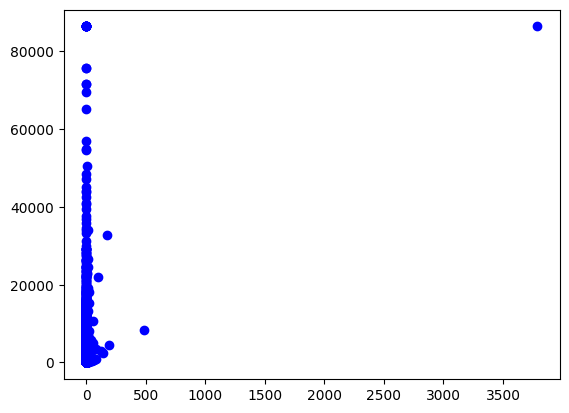

In [ ]:
plt.plot( df["Interruptions"],df["Playtime"], 'bo')

It shows the effect of Interruptions on the Playtime that have direct impact to Effective Playtime and it also shows outliers there

**Show important Value from every column**

In [6]:
# null values
null_values = df.isnull().sum()
df_nulls = pd.DataFrame({'Column':null_values.index, 'Nulls':null_values.values})

# Count non empty cells
df_count = df_nulls
df_count = df_count.rename(columns={"Nulls": "Count"})
nb_rows = df.shape[0] # 102256
df_count.iloc[:,1] = nb_rows - df_count.iloc[:,1]

# count unique cells
uniqueValues = df.nunique()
df_unique = pd.DataFrame({'Column':uniqueValues.index, 'Unique':uniqueValues.values})

# data types
dty = df.dtypes
df_dty = pd.DataFrame({'Column':dty.index, 'Type':dty.values})

In [7]:
# merge all together in one dataframe
analyzed_df = pd.concat([df_nulls.iloc[:,0], df_count.iloc[:,1], df_nulls.iloc[:,1], df_unique.iloc[:,1], df_dty.iloc[:,1]], axis = 1)
print(analyzed_df)

                    Column   Count   Nulls  Unique            Type
0                  Column1  102256       0  102256           int64
1               Start Time  102256       0   96503  datetime64[ns]
2                 Playtime  102256       0    4752           int64
3       Effective Playtime  102256       0    4440           int64
4            Interruptions  102256       0      43           int64
5                Join Time  102256       0    5554         float64
6             Buffer Ratio  102256       0    2076         float64
7            CDN Node Host   36979   65277     342          object
8          Connection Type  102256       0      19          object
9                   Device  102256       0      15          object
10             Device Type  102256       0      13          object
11                 Browser  102256       0      15          object
12         Browser Version  101411     845      64          object
13                      OS  102256       0       9          ob

From the result, it can be seen we have several columns containing missing value. It can also be seen column Programn_N just have 1 unique values and we can simply say it adds no value, all Zeros.

We also have both numerical and categorical data, for categorical data, we will encode it using Label Encoding

**3.1 Handling Missing Values**

Find several missing values in columns [CDN Node Host and Browser Version], Drop those columns because they have many missing value. For other column, fill the missing values with other values because we still need them.

Also delete column1 and Program_N.

Delete  Content_TV_Show_N due to the high cardinality.

Delete End Time since we will just use Start Time.

Delete Happiness Value' as Happiness score exists.

Delete Effective Playtime since it came from Interruptions and Playtime

In [8]:
df = df.drop(["Column1", "Effective Playtime", "CDN Node Host", "Browser Version", "Program_N", "End Time", "Happiness Value"], axis = 1)

#Fill Crash Status Column
df["Crash Status"] = df["Crash Status"].astype('category')
df["Crash Status"] = df["Crash Status"].cat.add_categories("No Error Crash").fillna("No Error Crash")
df["Crash Status"] = df["Crash Status"].astype('object')

#fill Happiness Value Column
# df["Happiness Value"] = df["Happiness Value"].astype('category')
# df["Happiness Value"] = df["Happiness Value"].fillna("Angry (0-3)")
# df["Happiness Value"] = df["Happiness Value"].astype('object')

#Fill End Of Playback Status Column
df["End of Playback Status"] = df["End of Playback Status"].astype('category')
df["End of Playback Status"] = df["End of Playback Status"].fillna("On Stop")
df["End of Playback Status"] = df["End of Playback Status"].astype('object')

df.isna().sum()

Start Time                0
Playtime                  0
Interruptions             0
Join Time                 0
Buffer Ratio              0
Connection Type           0
Device                    0
Device Type               0
Browser                   0
OS                        0
OS Version                0
Device ID                 0
Happiness Score           0
Playback Stalls           0
Startup Error (Count)     0
Latency                   0
Crash Status              0
End of Playback Status    0
User_ID_N                 0
Title_N                   0
Device_Vendor_N           0
Device_Model_N            0
Content_TV_Show_N         0
Country_N                 0
City_N                    0
Region_N                  0
dtype: int64

There are no more missing values

In [ ]:
df.shape

(102256, 26)

It can be seen after removing several columns, now the dataset just have 26 columns or variable there

**3.2 Preprocessing Data**

Set Start Time as index for time series data

In [9]:
df.set_index("Start Time", inplace=True)

**3.3 Exploratory Data Analysis (EDA)**

Show the distribution of data in every columns based on histogram and density in numerical data

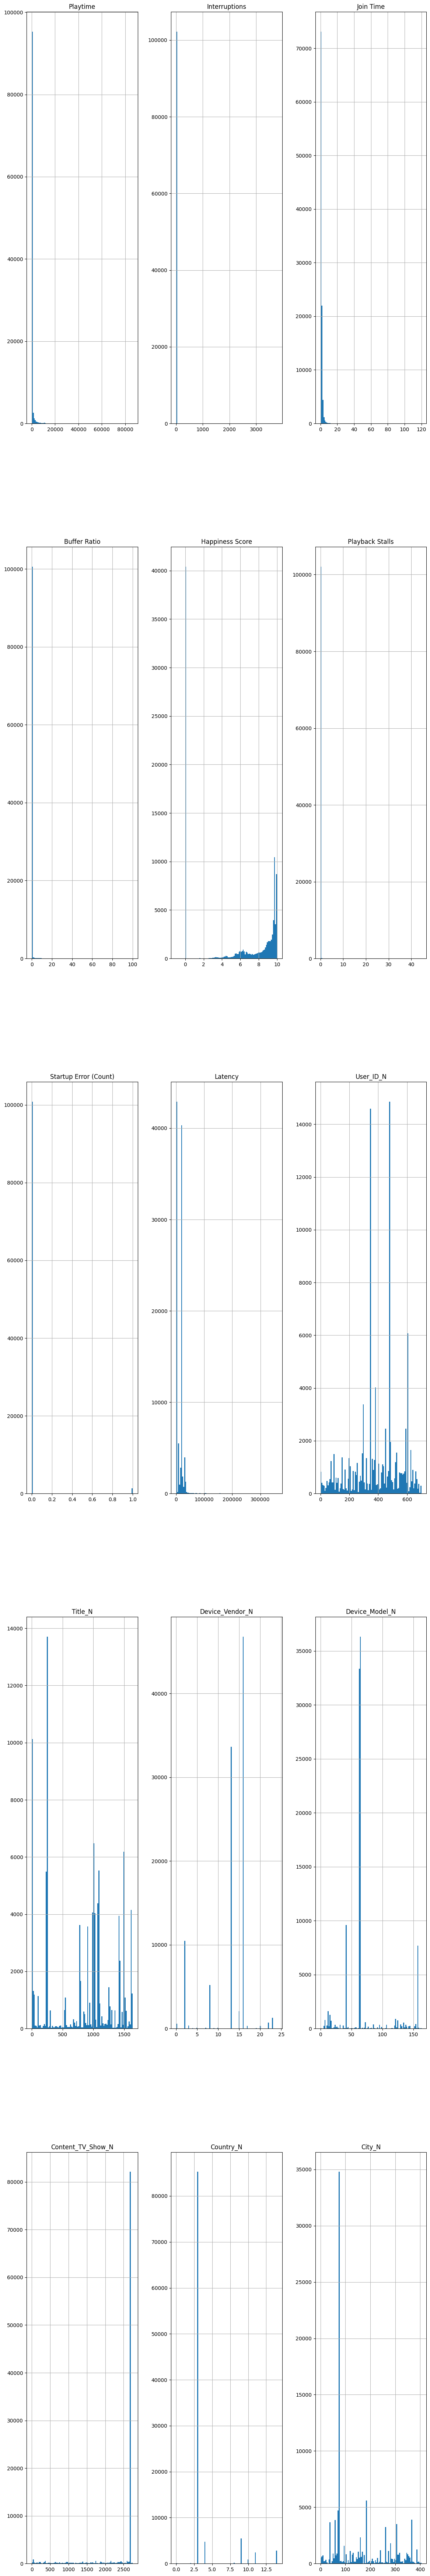

In [ ]:
# Select only float64 and int64 data types
df2 = df.select_dtypes(include=['float64', 'int64'])

fig, axes = plt.subplots(len(df2.columns)//3, 3, figsize=(14, 90))

i = 0
for triaxis in axes:
    for axis in triaxis:
        if i < len(df2.columns):
            df2.hist(column = df2.columns[i], bins = 100, ax=axis)
            i = i+1


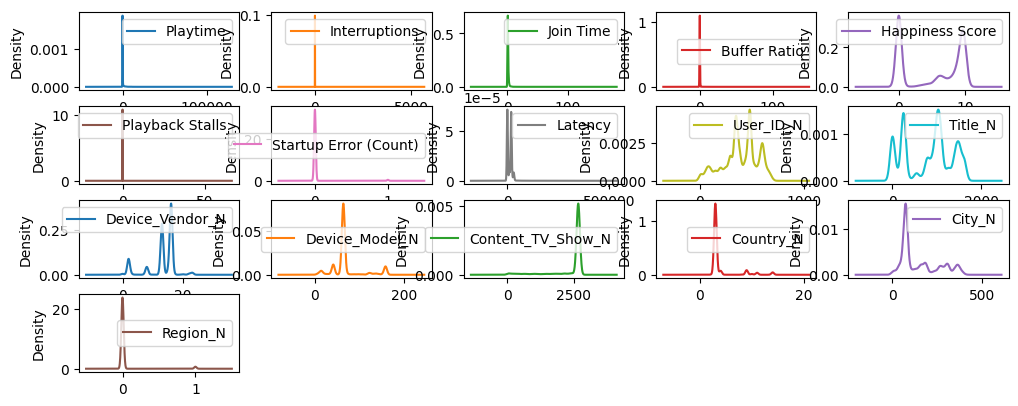

In [ ]:
df2.plot(kind='density',subplots=True,layout=(10,5),figsize=(12,12),sharex=False)
plt.show()

From the images it can be seen that the dataset have so many outliers on each features. Checking the outliers using distribution of data from all of the column including non numerical data

In [ ]:
df.describe()

Playtime  Interruptions      Join Time   Buffer Ratio  \
count  102256.000000  102256.000000  102256.000000  102256.000000   
mean      328.965479       0.099544       1.158462       0.261755   
std      1799.357645      12.007473       2.843884       3.568773   
min         0.000000       0.000000       0.000000       0.000000   
25%         4.000000       0.000000       0.583000       0.000000   
50%        22.000000       0.000000       0.790000       0.000000   
75%        90.000000       0.000000       1.302000       0.000000   
max     86404.000000    3786.000000     120.000000     100.000000   

       Happiness Score  Playback Stalls  Startup Error (Count)        Latency  \
count    102256.000000    102256.000000          102256.000000  102256.000000   
mean          5.166843         0.003805               0.013564   13360.818788   
std           4.381398         0.202198               0.115673   23550.856009   
min          -1.000000         0.000000               0.000000       0.000000   
25%           0.000000         0.000000               0.000000       0.000000   
50%           6.646500         0.000000               0.000000   17862.000000   
75%           9.607000         0.000000               0.000000   19235.000000   
max          10.000000        44.408000               1.000000  359477.000000   

           User_ID_N        Title_N  Device_Vendor_N  Device_Model_N  \
count  102256.000000  102256.000000    102256.000000   102256.000000   
mean      392.976686     809.658494        13.127699       69.461704   
std       161.309073     527.743379         4.624751       33.347175   
min         0.000000       0.000000         0.000000        0.000000   
25%       295.000000     261.000000        13.000000       63.000000   
50%       383.000000     997.000000        15.000000       64.000000   
75%       487.000000    1170.250000        16.000000       64.000000   
max       699.000000    1638.000000        24.000000      163.000000   

       Content_TV_Show_N      Country_N         City_N       Region_N  
count      102256.000000  102256.000000  102256.000000  102256.000000  
mean         2421.410568       3.933021     150.772669       0.027676  
std           631.704165       2.546806     107.740597       0.164043  
min             0.000000       0.000000       0.000000       0.000000  
25%          2672.000000       3.000000      76.000000       0.000000  
50%          2672.000000       3.000000      76.000000       0.000000  
75%          2672.000000       3.000000     240.000000       0.000000  
max          2746.000000      14.000000     405.000000       1.000000

It can be seen there is outlier in the dataset, plot the data to get a better view

<Axes: >

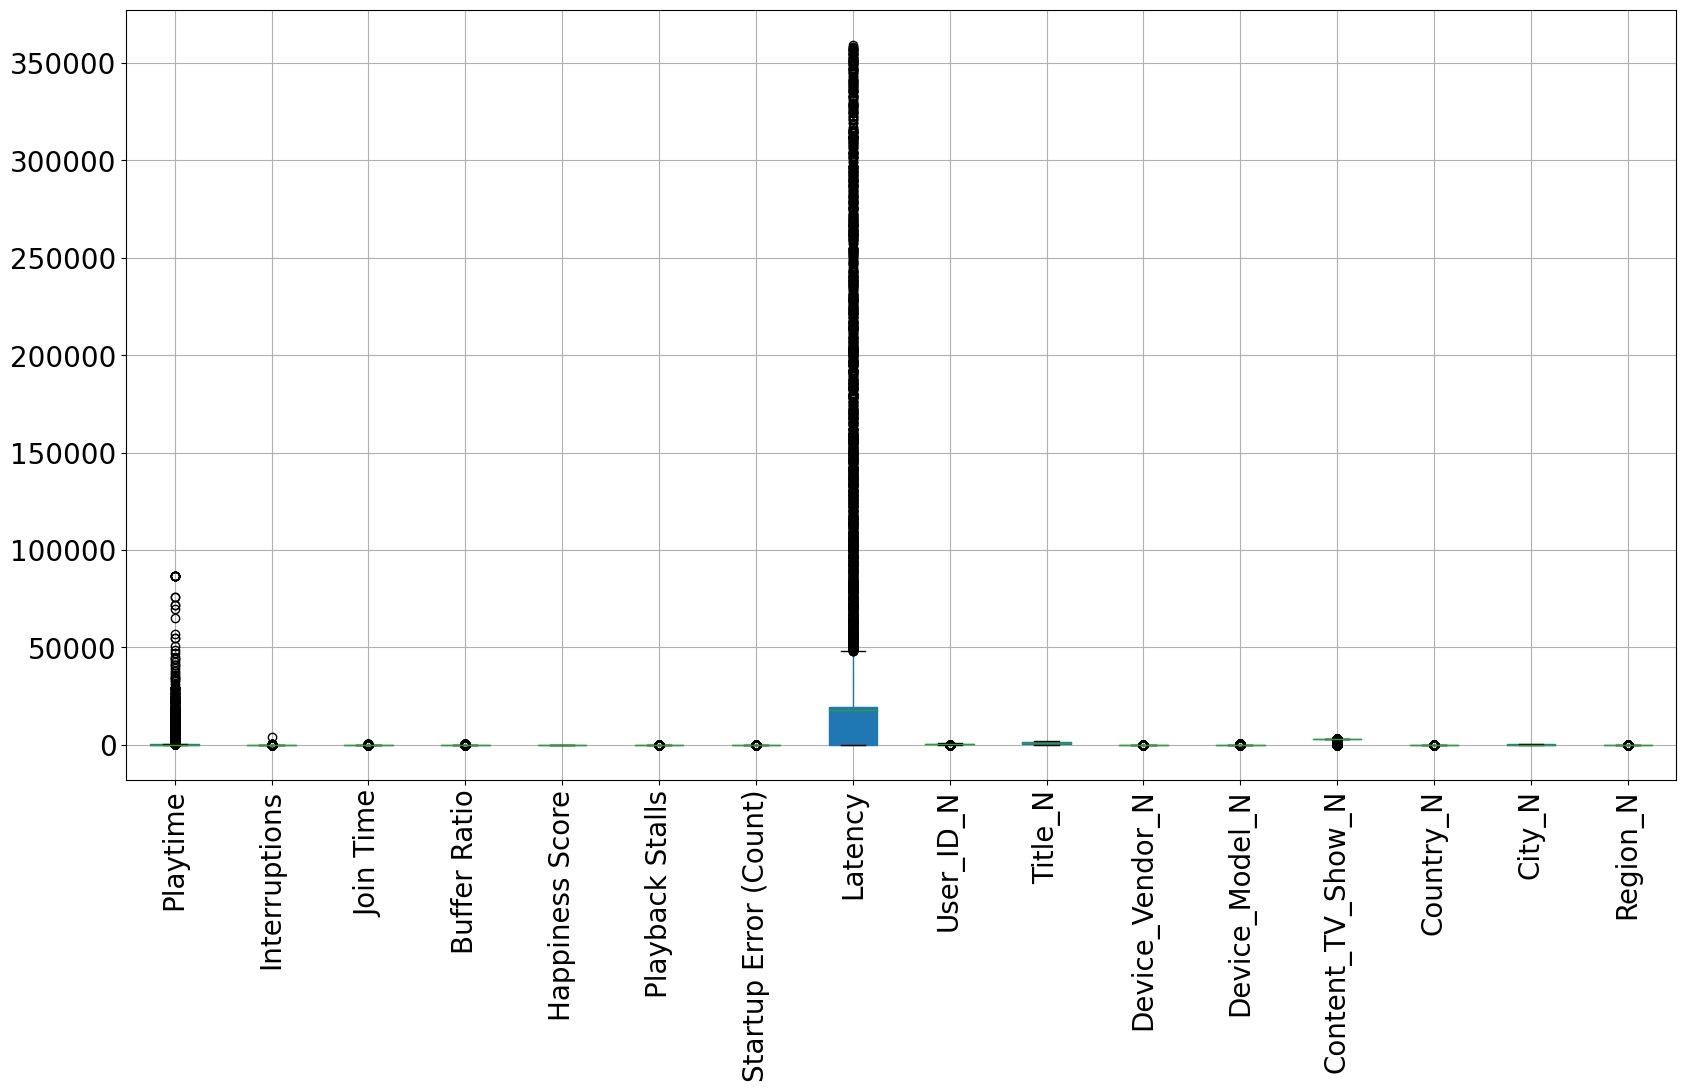

In [ ]:
df.boxplot(fontsize=20,rot=90,figsize=(20,10),patch_artist=True)

From the graph, it can be seen that the difference of data distribution between each features are really extreme because of the outliers. We will conduct further analysis to show why this outliers happend in the dataset.

**4. Time-Series Decomposition**

The time series dataset is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:
*   Level: The average value in the series.
*   Trend: The increasing or decreasing value in the series.
*   Seasonality: The repeating short-term cycle in the series.
*   Noise: The random variation in the series.

Decomposition is primarily used for time series analysis, and as an analysis tool it can be used to inform forecasting models on your problem.

It provides a structured way of thinking about a time series forecasting problem, both generally in terms of modeling complexity and specifically in terms of how to best capture each of these components in a given model.

The dataset are messy and noisy. There may be additive and multiplicative components. There may be an increasing trend followed by a decreasing trend. There may be non-repeating cycles mixed in with the repeating seasonality components.

In this section, exploring more about the dataset by decomposition method, we making new variable for a pair of column Playtime and Start Time. Choose Playtime because it represent main feature from time series data. in the following section we will focusing in this for the Time Series analysis.

In [ ]:
ts = df.groupby("Start Time")["Playtime"].sum().rename("playing_time")
ts.head()

Start Time
2022-07-12 00:00:14     11
2022-07-12 00:00:15    241
2022-07-12 00:00:25    124
2022-07-12 00:00:38     73
2022-07-12 00:01:52    254
Name: playing_time, dtype: int64

<Axes: xlabel='Start Time'>

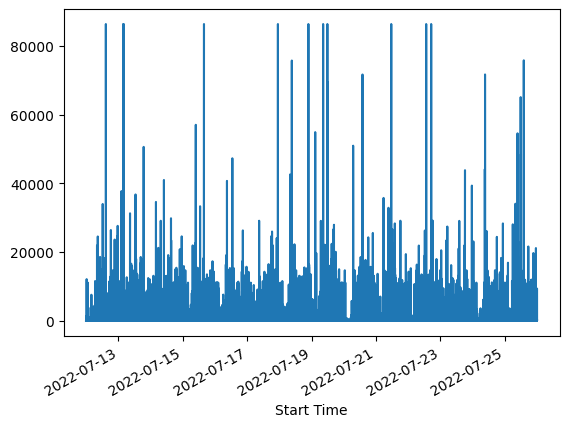

In [ ]:
ts.plot()

Choose periode 7 for weekly period dataset since the dataset just consist of 2 weeks time series data 

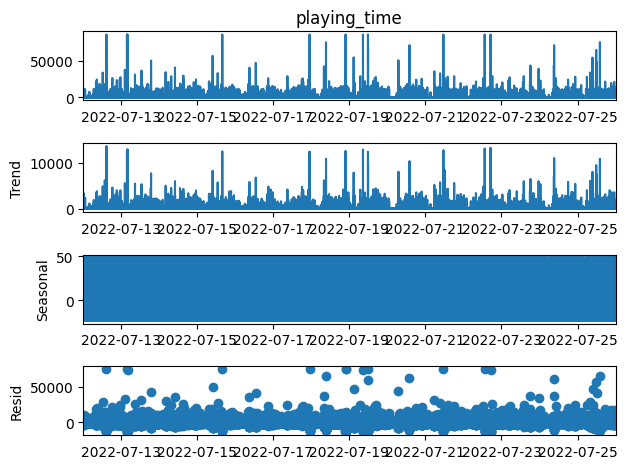

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts, period=7)
result.plot()
plt.show()

From the graph it can be seen that the dataset is not Trend or Seasonal time-series, it is highly likely a residual time series. To know more about it, we will digging it further and break it down one-by-one

**4.1 Trend Analysis**

The trend is the component of a time series that represents variations of low frequency in a time series, the high and medium frequency fluctuations having been filtered out.

The objective of this analysis is to understand if there is a trend in the data and whether this pattern is linear or not. The best tool for this job is visualization.

In [ ]:
'''
Plot ts with rolling mean and 95% confidence interval with rolling std.
:parameter    
  :param ts: pandas Series    
  :param window: num - for rolling stats
  :param plot_ma: bool - whether plot moving average
  :param plot_intervals: bool - whether plot upper and lower bounds
'''
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=30,
            figsize=(15,5)):    
   rolling_mean = ts.rolling(window=window).mean()    
   rolling_std = ts.rolling(window=window).std()
   plt.figure(figsize=figsize)    
   plt.title(ts.name)    
   plt.plot(ts[window:], label='Actual values', color="black")    
   if plot_ma:        
      plt.plot(rolling_mean, 'g', label='MA'+str(window),
               color="red")    
   if plot_intervals:
      lower_bound = rolling_mean - (1.96 * rolling_std)
      upper_bound = rolling_mean + (1.96 * rolling_std)
   plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound,
                    color='lightskyblue', alpha=0.4)
   plt.legend(loc='best')
   plt.grid(True)
   plt.show()

When the dataset has 2 weeks day of observation, start a rolling window with half of it, which is 7 days:

<ipython-input-27-53b3c5f9e5ce>:17: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.



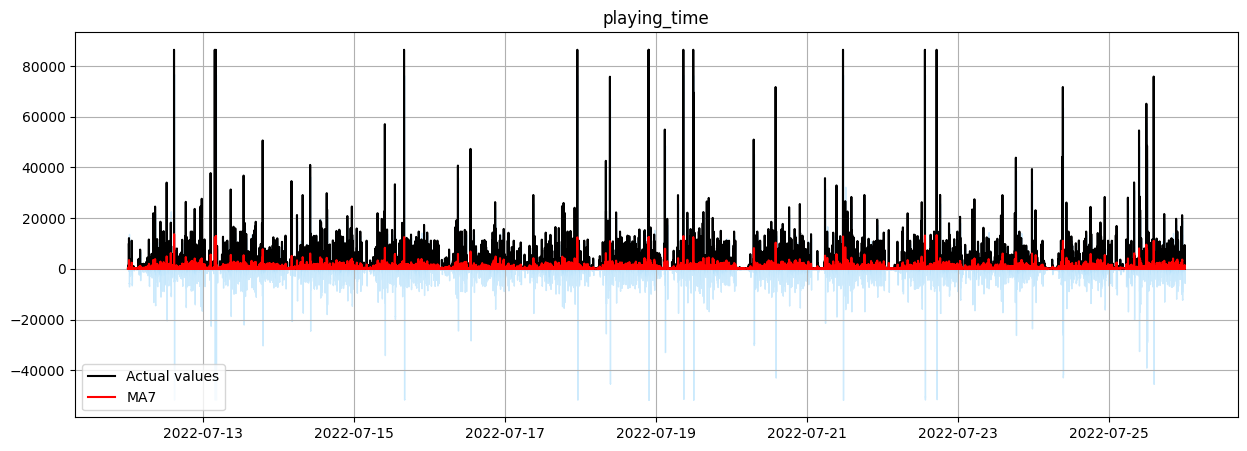

In [ ]:
plot_ts(ts, window=7)

Check at the red line in the plot, it can be seen a pattern similar with the time series plot

<ipython-input-27-53b3c5f9e5ce>:17: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.



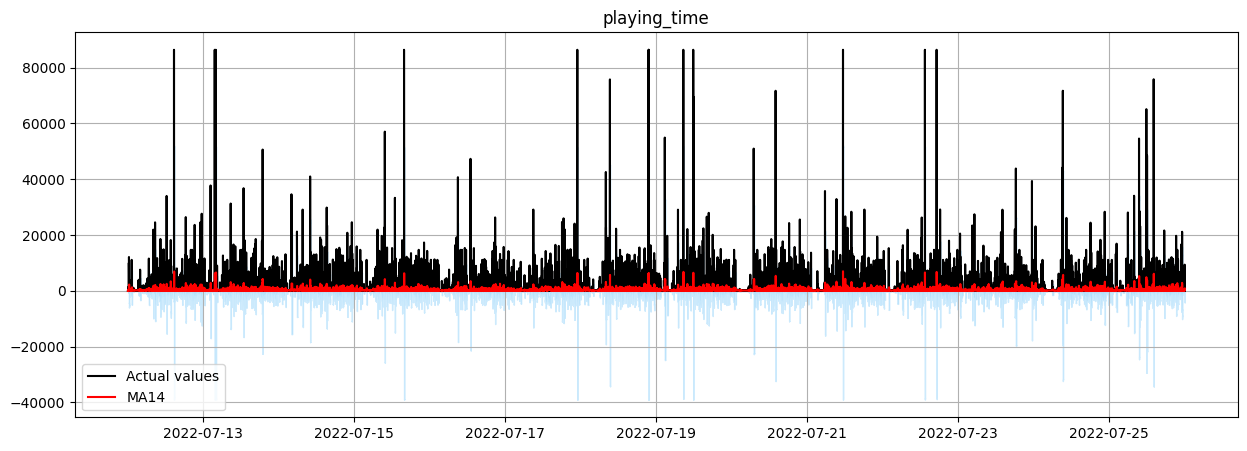

In [ ]:
plot_ts(ts, window=14)

When a rolling window of 2 weeks is used it is obvious getting more similar with the original time series itself. 

This is useful in model design as most of the models require to specify whether the trend component exists and whether it is linear (also said “additive”) or non-linear (also said“multiplicative”).

But is a clear, the dataset not have trend component exists and we can assume it is because the dataset itself is residual time series. 

**4.2 Stationarity Test**

A stationary process is a stochastic process whose unconditional joint probability distribution does not change when shifted in time. Consequently, parameters such as mean and variance also do not change over time, therefore stationary time series are easier to forecast.

There are several ways to establish whether a time series is stationary or not, the most common are good old visualization, looking at the autocorrelation and running statistical tests.

The most common Autocorrelation test is the Dickey-Fuller test (also called “ADF test”) where the null hypothesis is that the time series has a unit root, in other words, that the time series is not stationary. we will use this method for autocorrelation

In [ ]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(ts, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -56.426
P-value = 0.000
Critical values :
	1%: -3.4304177827253977 - The data is  stationary with 99% confidence
	5%: -2.861569958890621 - The data is  stationary with 95% confidence
	10%: -2.5667859460712474 - The data is  stationary with 90% confidence


From the result it seems the data is stationary, not residual

**4.3 Autocorrelation plots (ACF & PACF)**

Autocorrelation is Correlation which calculated between the variable and itself at previous time steps. This method is important to time series data analysis

An autocorrelation (ACF) plot represents the autocorrelation of the series with lags of itself.

A partial autocorrelation (PACF) plot represents the amount of correlation between a series and a lag of itself that is not explained by correlations at all lower-order lags.


In [ ]:
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as smt

def test_stationarity_acf_pacf(ts, sample=0.20, maxlag=30, figsize=(15,10)):
    with plt.style.context(style='bmh'):
        ## set figure
        fig = plt.figure(figsize=figsize)
        ts_ax = plt.subplot2grid(shape=(2,2), loc=(0,0), colspan=2)
        pacf_ax = plt.subplot2grid(shape=(2,2), loc=(1,0))
        acf_ax = plt.subplot2grid(shape=(2,2), loc=(1,1))
        
        ## plot ts with mean/std of a sample from the first x% 
        dtf_ts = ts.to_frame(name="ts")
        sample_size = int(len(ts)*sample)
        dtf_ts["mean"] = dtf_ts["ts"].head(sample_size).mean()
        dtf_ts["lower"] = dtf_ts["ts"].head(sample_size).mean() + dtf_ts["ts"].head(sample_size).std()
        dtf_ts["upper"] = dtf_ts["ts"].head(sample_size).mean() - dtf_ts["ts"].head(sample_size).std()
        dtf_ts["ts"].plot(ax=ts_ax, color="black", legend=False)
        dtf_ts["mean"].plot(ax=ts_ax, legend=False, color="red",
                            linestyle="--", linewidth=0.7)
        ts_ax.fill_between(x=dtf_ts.index, y1=dtf_ts['lower'], 
                y2=dtf_ts['upper'], color='lightskyblue', alpha=0.4)
        dtf_ts["mean"].head(sample_size).plot(ax=ts_ax,
                legend=False, color="red", linewidth=0.9)
        ts_ax.fill_between(x=dtf_ts.head(sample_size).index, 
                           y1=dtf_ts['lower'].head(sample_size), 
                           y2=dtf_ts['upper'].head(sample_size),
                           color='lightskyblue')
        
        ## test stationarity (Augmented Dickey-Fuller)
        adfuller_test = sm.tsa.stattools.adfuller(ts, maxlag=maxlag,
                                                  autolag="AIC")
        adf, p, critical_value = adfuller_test[0], adfuller_test[1], adfuller_test[4]["5%"]
        p = round(p, 3)
        conclusion = "Stationary" if p < 0.05 else "Non-Stationary"
        ts_ax.set_title('Dickey-Fuller Test 95%: '+conclusion+
                        '(p value: '+str(p)+')')
        
        ## pacf (for AR) e acf (for MA) 
        smt.plot_pacf(ts, lags=maxlag, ax=pacf_ax, 
                 title="Partial Autocorrelation (for AR component)")
        smt.plot_acf(ts, lags=maxlag, ax=acf_ax,
                 title="Autocorrelation (for MA component)")
        plt.tight_layout()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



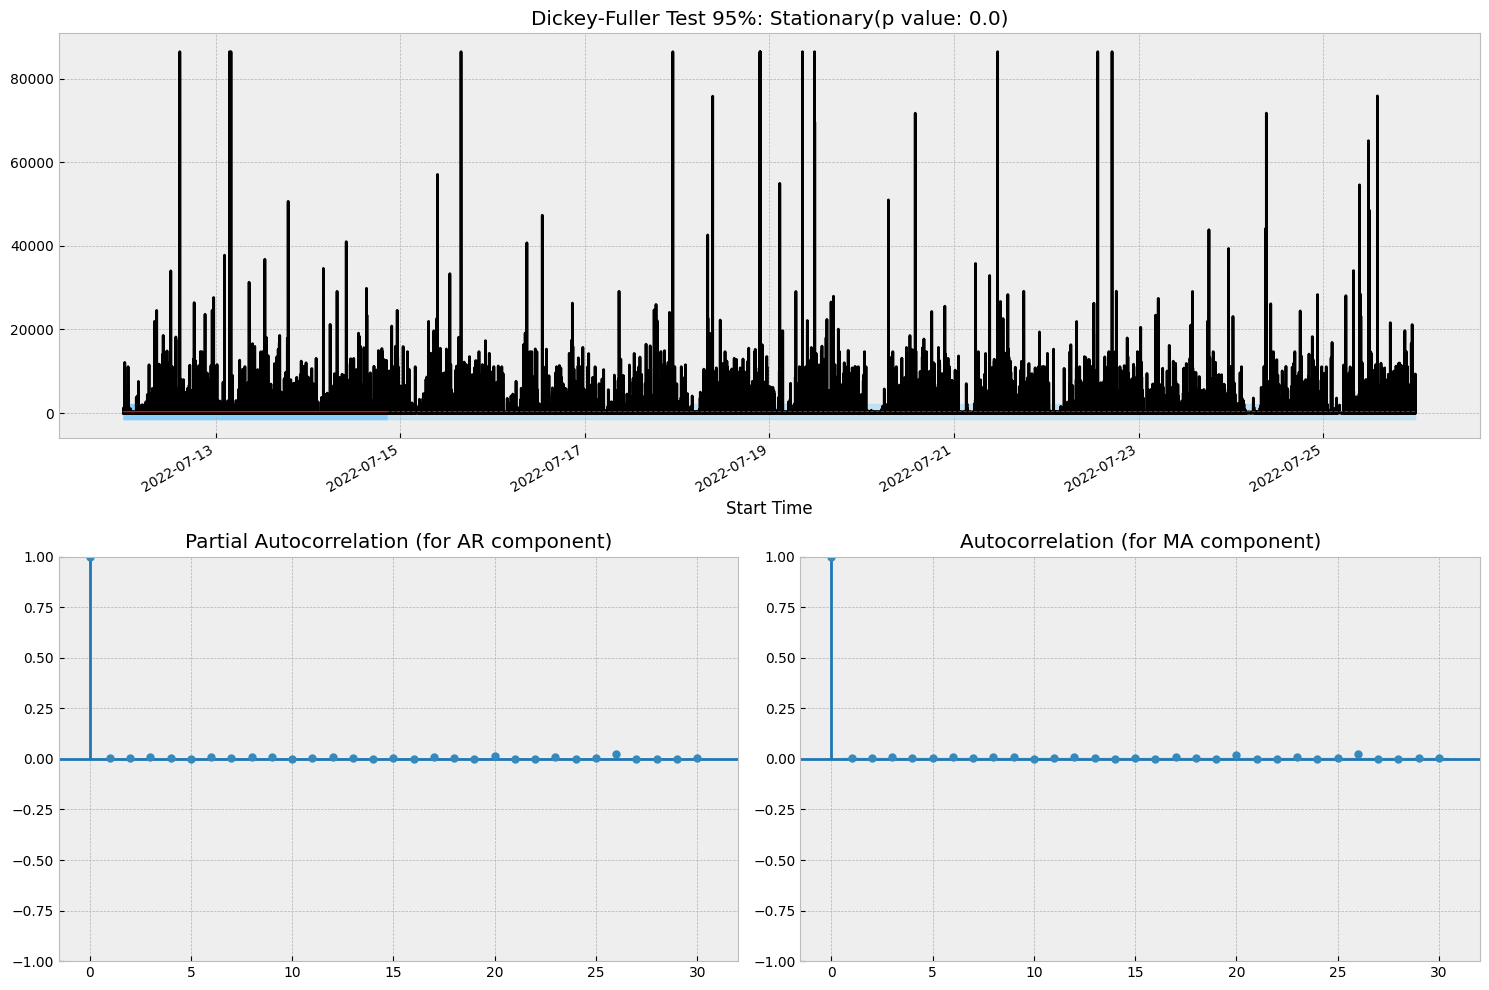

In [ ]:
test_stationarity_acf_pacf(ts, sample=0.20, maxlag=30)

From previous description we know that The Dickey-Fuller test is a statistical test used to determine whether a time series is stationary, which means its properties do not depend on the time at which the series is observed. In the context of the Dickey-Fuller test, the null hypothesis states that the time series has a unit root (i.e., it is non-stationary), while the alternative hypothesis states that it doesn't (i.e., it is stationary).

And a p-value is a measure of the probability that an observed result could have occurred under the null hypothesis. A p-value of 0 is very strong evidence against the null hypothesis.

The Dickey-Fuller test is a statistical test that is commonly used in time series analysis to test whether a given series is stationary. In simpler terms, it tests whether the series has a unit root. A unit root would suggest that the series is non-stationary, meaning it has some form of time-dependent structure such as a trend or seasonality.

And from the result, it shows Dickey-Fuller test at 95%, with p-value is 0. From this result, we can reject the null hypothesis and conclude that the series is stationary. Cause if p-value is greater than 0.05, it will fail to reject the null hypothesis and conclude that the series is non-stationary.

However, in real-world applications, it's almost impossible to get a p-value exactly equal to 0 due to the presence of sampling error. Except, from previous analysis we know that the dataset contains residual. This residual create fluctuation in the data, thus this fluctuation made the time series data in stationary form.

This result prove initial analysis that residual exist in the dataset, it can also be seen, there is no spikes above the blue region, meaning there is no correlation between series and lag itself. This happend caused by the residual itself. We obeserve it again with Seasonality Analysis to ensure what kind of residual exist in the dataset.

**4.4 Seasonality Analysis**

The seasonal component is that part of the variations in a time series representing 2 weeks of fluctuations with respect to timing, direction and magnitude.

The objective of this last section is to understand what kind of seasonality is affecting the data (weekly seasonality if it presents fluctuations every 7 days.

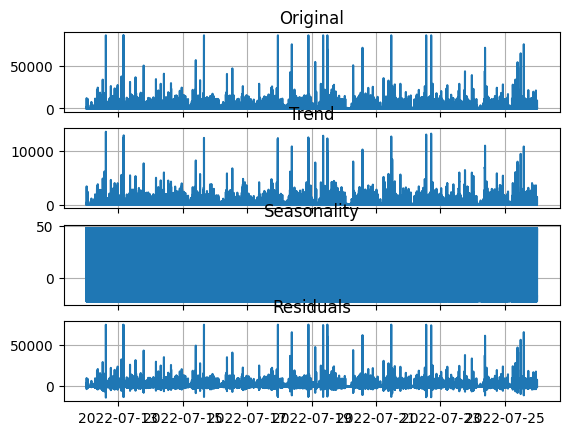

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=7)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid   
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=False)
ax[0].plot(ts)
ax[0].set_title('Original')
ax[0].grid(True) 
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[1].grid(True)  
ax[2].plot(seasonal)
ax[2].set_title('Seasonality')
ax[2].grid(True)  
ax[3].plot(residual)
ax[3].set_title('Residuals')
ax[3].grid(True)


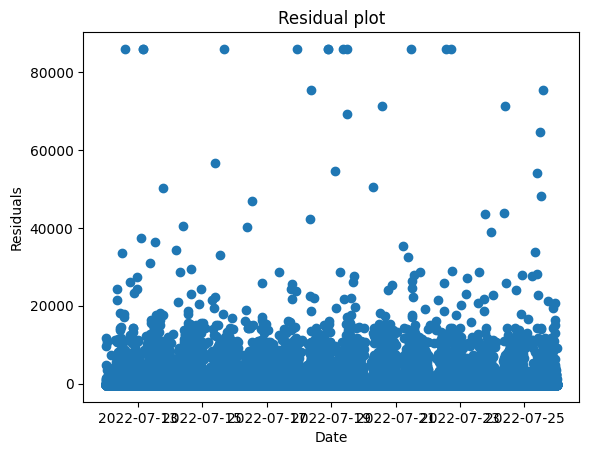

In [ ]:
tss = sm.add_constant(range(len(ts)))
model = sm.OLS(ts, tss).fit()

# Calculate residuals
residuals = model.resid

# Visualize residuals using a scatter plot
plt.scatter(ts.index, residuals)
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

If a time series shows a pattern but does not exhibit seasonality, it could be due to other factors such as trends, cycles, or irregular fluctuations. From graph above, it can be seen that the dataset is not trend or seasonality. So, it can be irregular fluctuation data

Irregular fluctuations, also known as noise or residuals, are random fluctuations in the data that cannot be explained by trends, cycles, or seasonality. Irregular fluctuations can be caused by measurement error, random events, or other factors.

But from stationary test we know that this data is in stationary form, which means that the stationary happend because the dataset have irregural fluctuation over the time and become residual data

**5. Time Series Forecasting**

**5.1 Vector Auto Regression (VAR)**

In this section, we will introduce to one of the most commonly used methods for multivariate time series forecasting – Vector Auto Regression (VAR).

In a VAR algorithm, each variable is a linear function of the past values of itself and the past values of all the other variables. VAR is able to understand and use the relationship between several variables. This is useful for describing the dynamic behavior of the data and also provides better forecasting results. Additionally, implementing VAR is as simple as using any other univariate technique.

With VAR models, it is possible to elucidate the values of endogenous variables by considering their previously observed values

**Perform Label Encoding for Categorical Data before forecasting**

In [10]:
for i in df.select_dtypes('object').columns:
  le = LabelEncoder().fit(df[i])
  df[i] = le.transform(df[i]) 

df.head()

Playtime  Interruptions  Join Time  Buffer Ratio  \
Start Time                                                              
2022-07-12 00:00:14        11              0      0.879           0.0   
2022-07-12 00:00:38        73              0      1.170           0.0   
2022-07-12 00:02:02        21              0      1.133           0.0   
2022-07-12 00:02:24         1              0      0.000           0.0   
2022-07-12 00:02:25         1              0      0.000           0.0   

                     Connection Type  Device  Device Type  Browser  OS  \
Start Time                                                               
2022-07-12 00:00:14                7       1           10        0   0   
2022-07-12 00:00:38               16       1           10        0   0   
2022-07-12 00:02:02               16       1           10        0   0   
2022-07-12 00:02:24               16       1           10        0   0   
2022-07-12 00:02:25               16       1           10        0   0   

                     OS Version  Device ID  Happiness Score  Playback Stalls  \
Start Time                                                                     
2022-07-12 00:00:14           0        209            7.393              0.0   
2022-07-12 00:00:38           0        387            9.399              0.0   
2022-07-12 00:02:02           0        197            6.999              0.0   
2022-07-12 00:02:24           0        197            0.000              0.0   
2022-07-12 00:02:25           0        197            0.000              0.0   

                     Startup Error (Count)  Latency  Crash Status  \
Start Time                                                          
2022-07-12 00:00:14                      0    19504             1   
2022-07-12 00:00:38                      0    19033             1   
2022-07-12 00:02:02                      0    19071             1   
2022-07-12 00:02:24                      0        0             1   
2022-07-12 00:02:25                      0        0             1   

                     End of Playback Status  User_ID_N  Title_N  \
Start Time                                                        
2022-07-12 00:00:14                       3        564      784   
2022-07-12 00:00:38                       3        480        1   
2022-07-12 00:02:02                       3        346      786   
2022-07-12 00:02:24                       3        346      997   
2022-07-12 00:02:25                       3        346      997   

                     Device_Vendor_N  Device_Model_N  Content_TV_Show_N  \
Start Time                                                                
2022-07-12 00:00:14               16              64               2672   
2022-07-12 00:00:38               13              63               2672   
2022-07-12 00:02:02               13              63               2672   
2022-07-12 00:02:24               13              63               2672   
2022-07-12 00:02:25               13              63               2672   

                     Country_N  City_N  Region_N  
Start Time                                        
2022-07-12 00:00:14          3     263         0  
2022-07-12 00:00:38          3      76         0  
2022-07-12 00:02:02          3      76         0  
2022-07-12 00:02:24          3      76         0  
2022-07-12 00:02:25          3      76         0

In [11]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

data = df

# Check for stationarity of the time series
def adf_test(series, signif=0.05):
    result = adfuller(series, autolag='AIC')
    pvalue = result[1]
    if pvalue <= signif:
        return True
    else:
        return False

# If any of the series are not stationary, apply differencing until they become stationary
non_stationary_variables = [var for var in data.columns if not adf_test(data[var])]

while len(non_stationary_variables) > 0:
    data = data.diff().dropna()
    non_stationary_variables = [var for var in data.columns if not adf_test(data[var])]

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Fit the VAR model
model = VAR(train_data)
best_aic = np.inf
best_order = None

# Find the best order (p) for the VAR model
for p in range(1, 10):
    result = model.fit(p)
    if result.aic < best_aic:
        best_aic = result.aic
        best_order = p

# Fit the VAR model with the best order
var_model = model.fit(best_order)
print(var_model.summary())

# Forecast the next n steps
n_steps = len(test_data)
forecast = var_model.forecast(train_data.values[-best_order:], steps=n_steps)

# Calculate RMSE and other evaluation metrics if necessary
forecast_df = pd.DataFrame(forecast, index=test_data.index, columns=test_data.columns)
rmse_values = {var: rmse(test_data[var], forecast_df[var]) for var in test_data.columns}
print("RMSE values for each variable: ", rmse_values)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.



Streaming output truncated to the last 5000 lines.
L6.Device                         0.003227         0.010569            0.305           0.760
L6.Device Type                   -0.008319         0.008641           -0.963           0.336
L6.Browser                        0.005387         0.012653            0.426           0.670
L6.OS                             0.005355         0.039462            0.136           0.892
L6.OS Version                    -0.003898         0.004125           -0.945           0.345
L6.Device ID                     -0.000022         0.000029           -0.750           0.453
L6.Happiness Score                0.000915         0.003513            0.261           0.794
L6.Playback Stalls               -0.082624         0.061181           -1.350           0.177
L6.Startup Error (Count)         -0.501526         0.295501           -1.697           0.090
L6.Latency                       -0.000000         0.000001           -0.082           0.935
L6.Crash Status    

From the RMSE result it can be seen variable with the best RMSE is Playback Stalls with RSME 0.07 and the worst is Latency with RMSE 19827.84. 

This differences happend because residual data in each features is also different. From the result we can say that Latency have more residual than Playback Stall

**5.1.1 Change Detection Using CUSUM Detector Method**

CUSUM (Cumulative Sum) detector is a statistical algorithm used for detecting changes or shifts in the mean or variance of a time series data.

The basic idea behind the CUSUM algorithm is to calculate the cumulative sum of the deviations of the data points from the mean or target value. If the sum exceeds a certain threshold, it indicates a change point.

We perform change detection between actual and forecast data using CUSUM method

In [12]:
from sklearn.metrics import mean_absolute_error

# Align the indexes of test_data and forecast_df
aligned_test_data, aligned_forecast_df = test_data.align(forecast_df, axis=0)

In [13]:
import numpy as np

def cusum(series, threshold):
    mean = series.mean()
    cusum_pos = np.zeros(len(series))
    cusum_neg = np.zeros(len(series))
    
    for t in range(1, len(series)):
        cusum_pos[t] = max(0, cusum_pos[t-1] + series[t] - mean - threshold)
        cusum_neg[t] = max(0, cusum_neg[t-1] - series[t] + mean - threshold)
    
    return cusum_pos, cusum_neg

# Calculate the difference between actual and forecast data
difference = aligned_test_data - aligned_forecast_df

# Set the threshold as the Mean Absolute Error (MAE)
threshold = {var: mean_absolute_error(aligned_test_data[var], aligned_forecast_df[var]) for var in test_data.columns}

# Apply CUSUM method and find significant changes
change_detection = {}

for var in test_data.columns:
    cusum_pos, cusum_neg = cusum(difference[var], threshold[var])
    change_detection[var] = (cusum_pos > 0) | (cusum_neg > 0)

# Print the significant changes
print("Significant changes:")
for var in test_data.columns:
    changes = change_detection[var][change_detection[var]]
    print(f"{var} ({len(changes)} changes):")
    print(changes)


Significant changes:
Playtime (6358 changes):
[ True  True  True ...  True  True  True]
Interruptions (5629 changes):
[ True  True  True ...  True  True  True]
Join Time (8824 changes):
[ True  True  True ...  True  True  True]
Buffer Ratio (7218 changes):
[ True  True  True ...  True  True  True]
Connection Type (8598 changes):
[ True  True  True ...  True  True  True]
Device (6949 changes):
[ True  True  True ...  True  True  True]
Device Type (7397 changes):
[ True  True  True ...  True  True  True]
Browser (7278 changes):
[ True  True  True ...  True  True  True]
OS (7211 changes):
[ True  True  True ...  True  True  True]
OS Version (6959 changes):
[ True  True  True ...  True  True  True]
Device ID (14676 changes):
[ True  True  True ...  True  True  True]
Happiness Score (16337 changes):
[ True  True  True ...  True  True  True]
Playback Stalls (6526 changes):
[ True  True  True ...  True  True  True]
Startup Error (Count) (7082 changes):
[ True  True  True ...  True  True  True

<ipython-input-14-c58af17bb7c7>:26: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



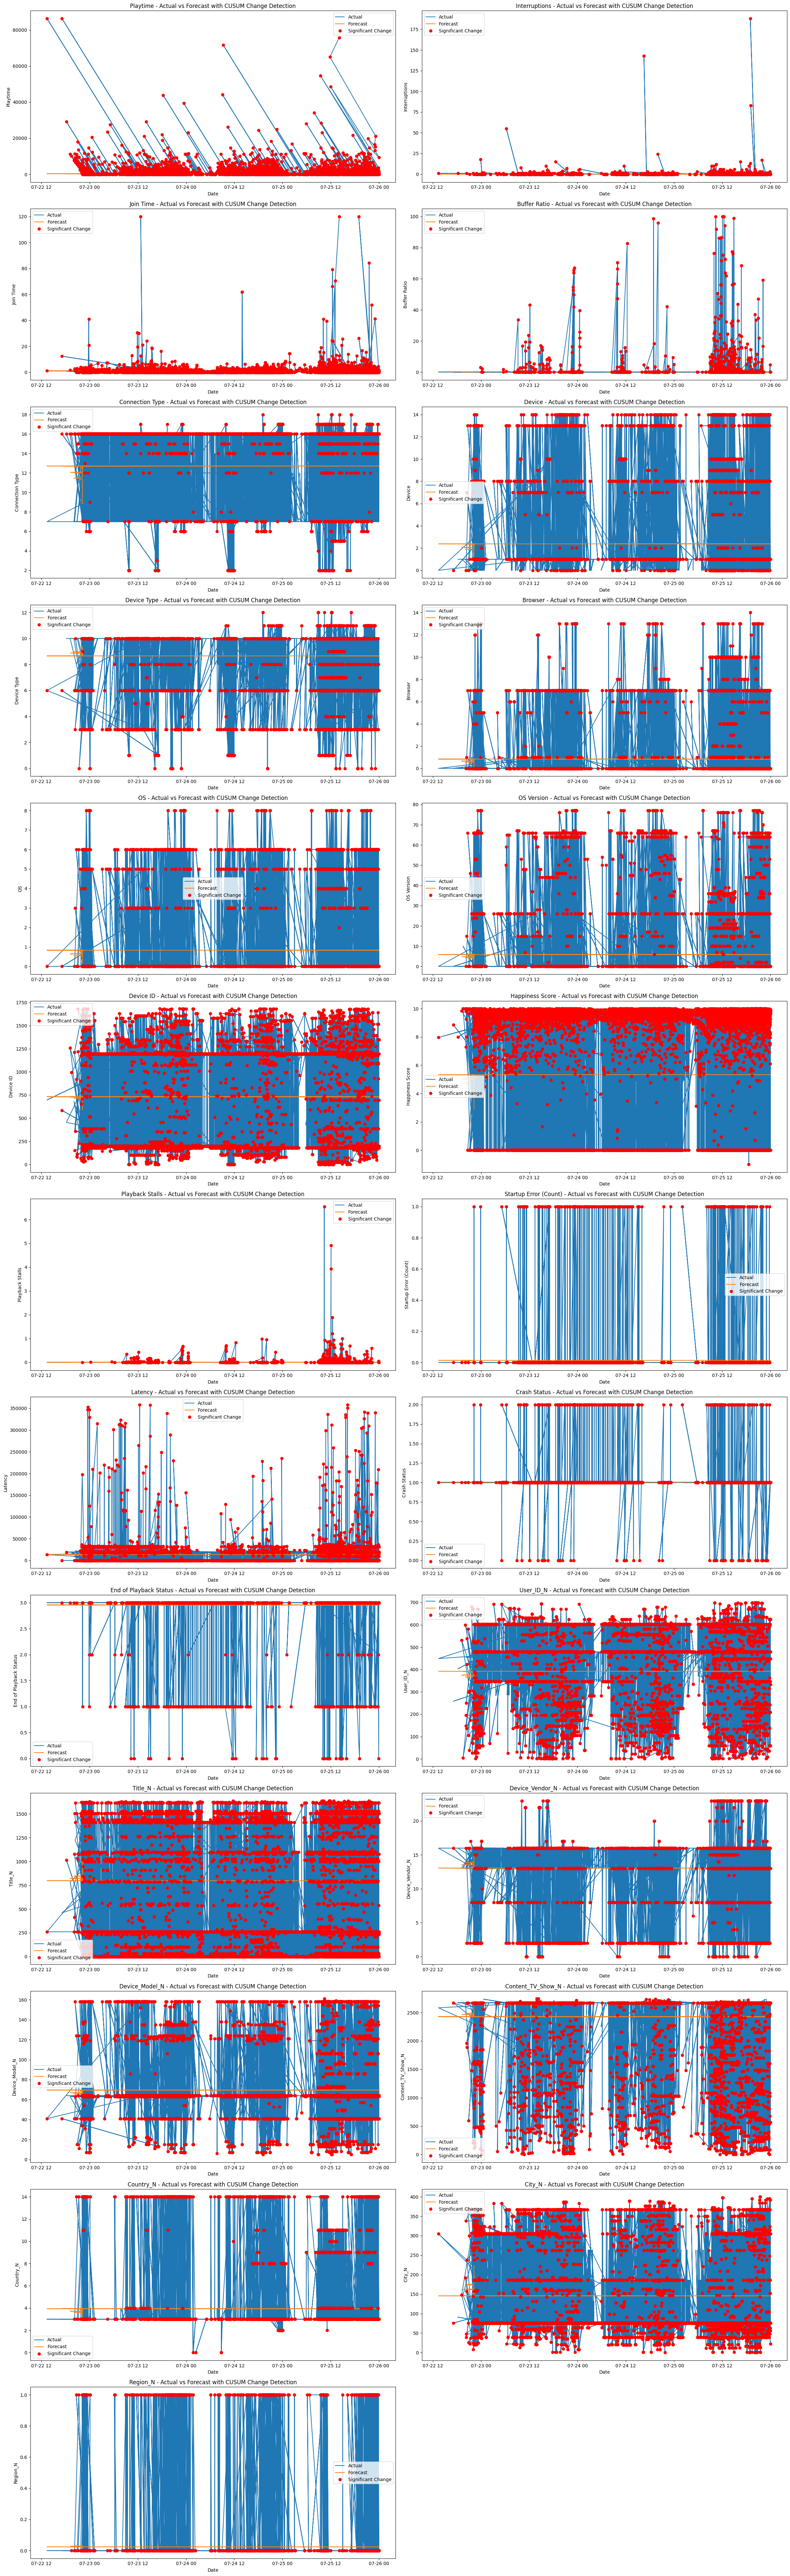

In [14]:
# Plot the CUSUM change detection results
n_variables = len(test_data.columns)
n_cols = 2
n_rows = (n_variables + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12 * n_cols, 6 * n_rows))

for ax, var in zip(axes.flatten(), test_data.columns):
    ax.plot(aligned_test_data.index, aligned_test_data[var], label='Actual')
    ax.plot(aligned_forecast_df.index, aligned_forecast_df[var], label='Forecast')
    
    significant_changes = np.where(change_detection[var])[0]
    for change_idx in significant_changes:
        change_date = aligned_test_data.index[change_idx]
        ax.plot(change_date, aligned_test_data[var].iloc[change_idx], 'ro', label='Significant Change' if change_idx == significant_changes[0] else None)

    ax.set_xlabel('Date')
    ax.set_ylabel(var)
    ax.set_title(f'{var} - Actual vs Forecast with CUSUM Change Detection')
    ax.legend()

# Remove any unused subplots
for ax in axes.flatten()[n_variables:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


From the graph, it can be seen there are change-point detected in every features. Sudden change-point appear on almost every point on every features. The CUSUM chart plots the cumulative sum of differences between the data points and the mean. A significant shift away from zero in the CUSUM plot indicates a change in the process mean.

too many changes detected by CUSUM in the plots shows that dataset has high variability, then it can cause frequent shifts in the CUSUM plot, leading to many detected changes. This could indicate that the process is out of control or unstable. 

This unstable events happend caused by outliers or extreme values in the data and cause abrupt changes in the CUSUM plot. These can occur due to measurement errors or unusual events which happend caused data that contains outliers not match with the forecast. 

We detecting changes by comparing actual data with forecast data and it shows they are not match at all cause outliers heavily involved on it. Thus it resulting change detected almost on every data points.

**5.1.2 windown Based**

Window-based change point detection is used to perform fast signal segmentation, we use window-based algorithm implemented in ruptures library. The algorithm uses two windows which slide along the time series data. The statistical properties of the signals within each window are compared with a discrepancy measure. If the sliding windows both fall into a segment, their statistical properties are similar and the discrepancy between the first window and the second window is low. If the sliding windows fall into two dissimilar segments, the discrepancy is significantly higher, suggesting that the boundary between windows is a change point. A sequential peak search is performed on the discrepancy curve in order to detect change points.

The benefits of window-based segmentation includes low complexity, also it can extend any single change point detection method to detect multiple changes points and that it can work whether the number of regimes is known beforehand or not.


In [15]:
!pip install ruptures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.5 MB/s eta 0:00:00


We detecting changes on test data and forecast data to see the performance of the model

In [19]:
import ruptures as rpt

# Assuming df is your actual data DataFrame and forecast_df is your forecast data DataFrame
# and they both have the same column structure

for column in df.columns:
    # Get the data for the current column
    actual_data = test_data[column].values
    forecast_data = forecast_df[column].values

    # Define the model
    model = "l2"  # "l1", "rbf", "linear", "normal", "ar"

    # Define the window width
    width = 40

    # Perform window-based change point detection for actual data
    algo_actual = rpt.Window(width=width, model=model).fit(actual_data)
    breakpoints_actual = algo_actual.predict(n_bkps=1)

    # Perform window-based change point detection for forecast data
    algo_forecast = rpt.Window(width=width, model=model).fit(forecast_data)
    breakpoints_forecast = algo_forecast.predict(n_bkps=1)

    # Print the change points
    print(f"Change points for {column} (Actual): {breakpoints_actual}")
    print(f"Change points for {column} (Forecast): {breakpoints_forecast}")


Change points for Playtime (Actual): [20430, 20452]
Change points for Playtime (Forecast): [20, 20452]
Change points for Interruptions (Actual): [10125, 20452]
Change points for Interruptions (Forecast): [20, 20452]
Change points for Join Time (Actual): [15320, 20452]
Change points for Join Time (Forecast): [20, 20452]
Change points for Buffer Ratio (Actual): [6515, 20452]
Change points for Buffer Ratio (Forecast): [20, 20452]
Change points for Connection Type (Actual): [8805, 20452]
Change points for Connection Type (Forecast): [20, 20452]
Change points for Device (Actual): [13920, 20452]
Change points for Device (Forecast): [20, 20452]
Change points for Device Type (Actual): [4330, 20452]
Change points for Device Type (Forecast): [20, 20452]
Change points for Browser (Actual): [10560, 20452]
Change points for Browser (Forecast): [20, 20452]
Change points for OS (Actual): [10560, 20452]
Change points for OS (Forecast): [20, 20452]
Change points for OS Version (Actual): [10560, 20452]


Change points for Playtime: [1310, 3110, 3230, 4300, 6025, 8055, 8795, 10290, 11680, 12585, 12940, 12965, 17370, 17435, 20452]


<Figure size 1000x600 with 0 Axes>

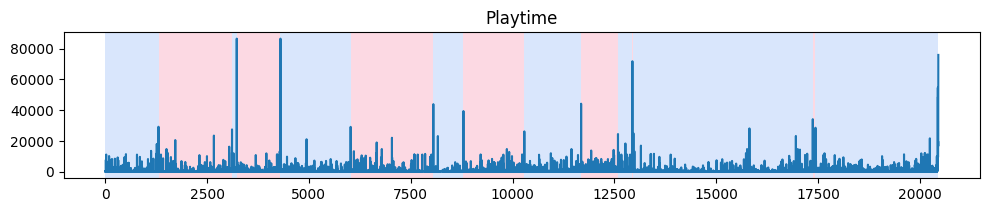

Change points for Interruptions: [935, 2315, 4405, 6105, 9310, 10140, 11870, 13610, 14150, 17225, 17875, 17945, 18330, 20075, 20452]


<Figure size 1000x600 with 0 Axes>

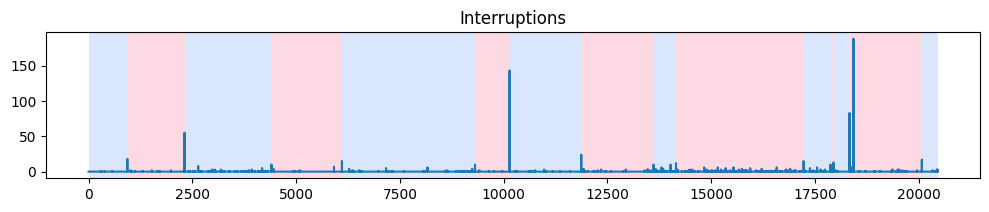

Change points for Join Time: [725, 2915, 2995, 3170, 9645, 9655, 13930, 14480, 15325, 15600, 19370, 19610, 19695, 20445, 20452]


<Figure size 1000x600 with 0 Axes>

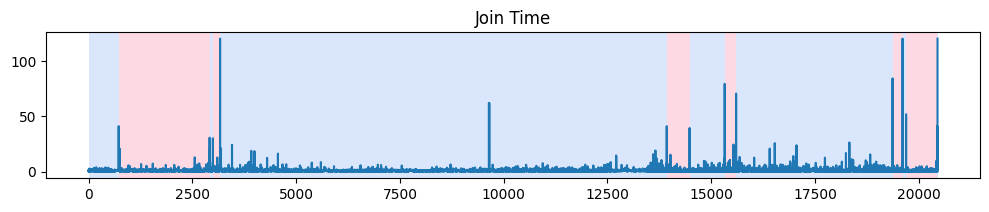

Change points for Buffer Ratio: [10640, 11030, 13800, 14055, 14175, 14560, 14845, 14945, 15070, 15320, 15460, 16260, 16390, 16545, 20452]


<Figure size 1000x600 with 0 Axes>

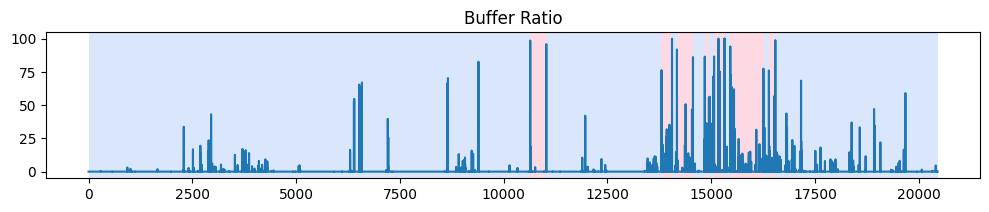

Change points for Connection Type: [6400, 8855, 9045, 9120, 9225, 13445, 13545, 13560, 13575, 13595, 14175, 15080, 17545, 19605, 20452]


<Figure size 1000x600 with 0 Axes>

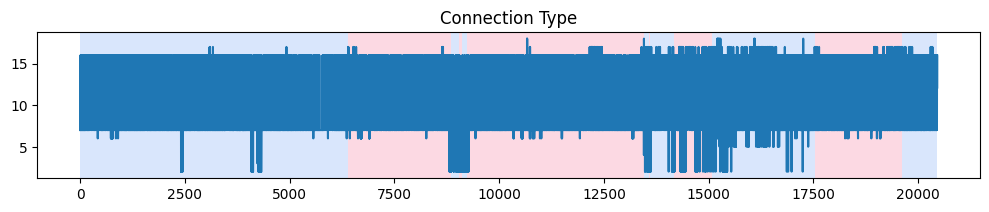

Change points for Device: [5370, 5480, 6275, 7275, 8340, 12205, 13445, 17695, 18955, 19455, 19520, 19885, 20230, 20365, 20452]


<Figure size 1000x600 with 0 Axes>

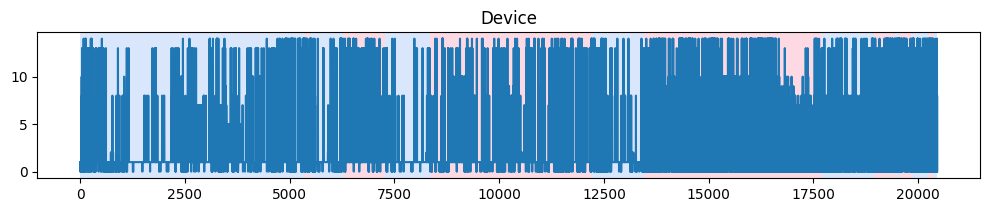

Change points for Device Type: [895, 1845, 2420, 5345, 5915, 11205, 11225, 13545, 13560, 14245, 15965, 17810, 17835, 18280, 20452]


<Figure size 1000x600 with 0 Axes>

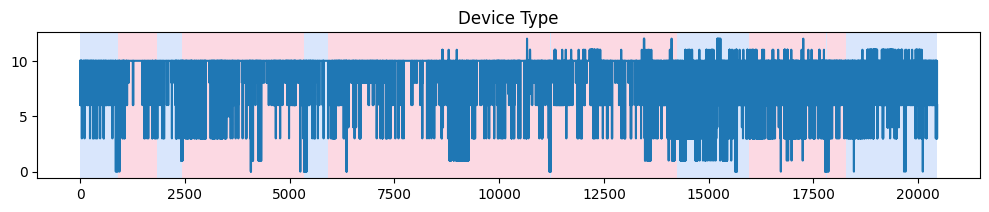

Change points for Browser: [745, 755, 900, 6700, 6710, 6895, 8975, 9165, 10335, 10730, 14490, 15105, 16470, 19530, 20452]


<Figure size 1000x600 with 0 Axes>

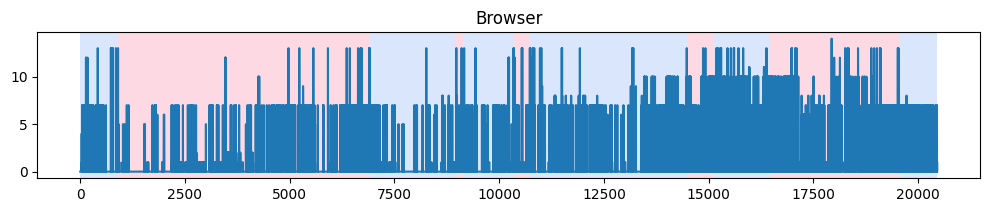

Change points for OS: [900, 8340, 8975, 9165, 10730, 12205, 13445, 17695, 18955, 19455, 19520, 19885, 20230, 20365, 20452]


<Figure size 1000x600 with 0 Axes>

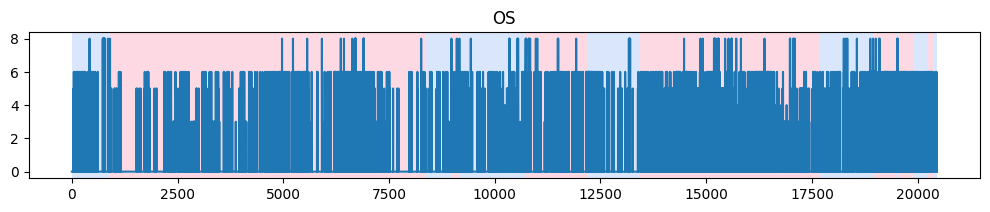

Change points for OS Version: [45, 900, 5370, 5480, 6275, 6330, 7100, 7275, 8340, 10730, 17695, 19530, 20230, 20365, 20452]


<Figure size 1000x600 with 0 Axes>

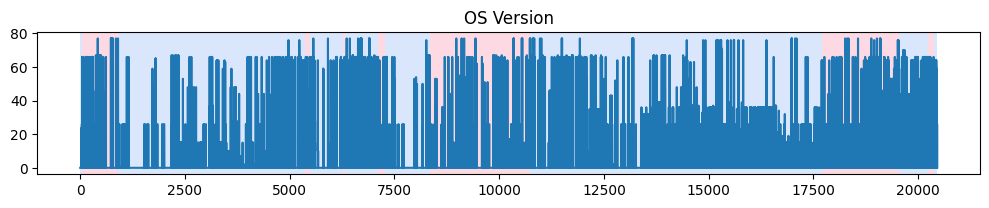

Change points for Device ID: [410, 1130, 2800, 3410, 3940, 5790, 6575, 9525, 11350, 13525, 13545, 15035, 16165, 18680, 20452]


<Figure size 1000x600 with 0 Axes>

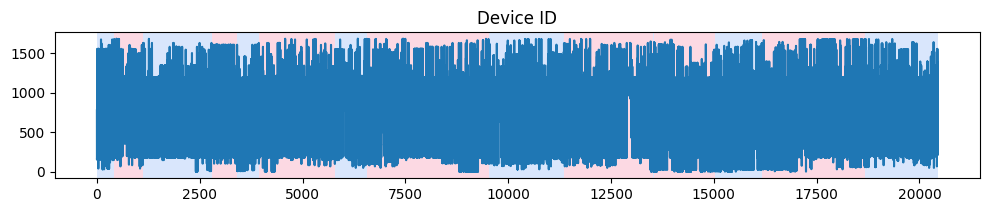

Change points for Happiness Score: [2160, 3735, 4400, 6960, 7830, 8380, 9845, 9890, 10985, 12595, 17660, 18495, 19850, 19995, 20452]


<Figure size 1000x600 with 0 Axes>

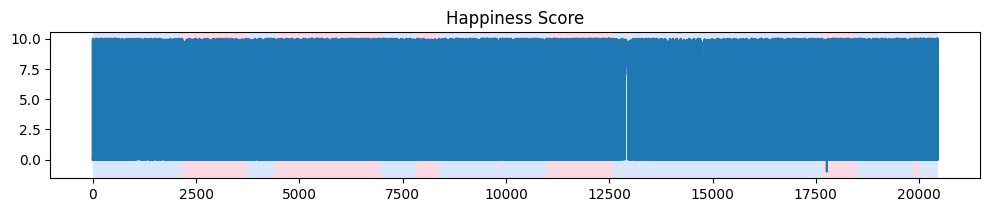

Change points for Playback Stalls: [9390, 10640, 11030, 14055, 14175, 14560, 14845, 14945, 15070, 15175, 15325, 15460, 16260, 16545, 20452]


<Figure size 1000x600 with 0 Axes>

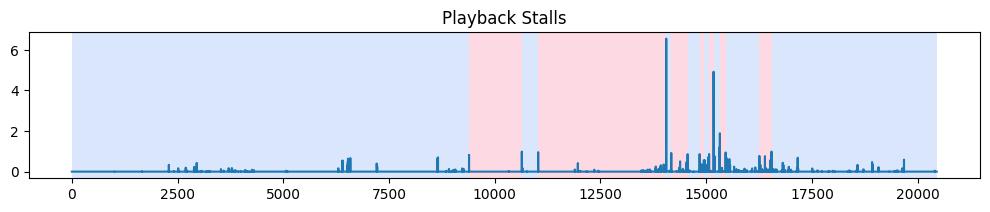

Change points for Startup Error (Count): [2325, 4085, 4280, 4290, 6575, 13930, 15325, 18120, 18280, 18670, 19385, 19530, 19715, 20330, 20452]


<Figure size 1000x600 with 0 Axes>

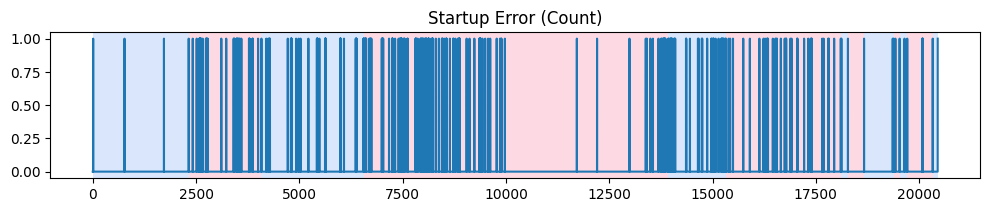

Change points for Latency: [555, 645, 805, 850, 1890, 3030, 3775, 4850, 5295, 15245, 16900, 18620, 19110, 20105, 20452]


<Figure size 1000x600 with 0 Axes>

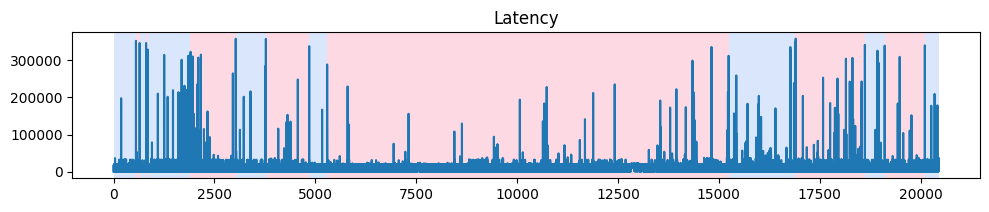

Change points for Crash Status: [2325, 2580, 3410, 4085, 4280, 4290, 6575, 15390, 15495, 16105, 16135, 17690, 20075, 20420, 20452]


<Figure size 1000x600 with 0 Axes>

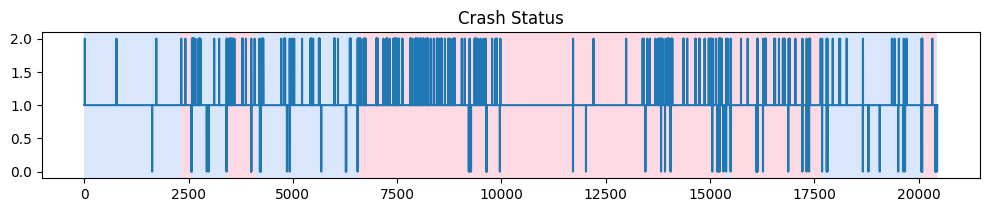

Change points for End of Playback Status: [2325, 3780, 3790, 4085, 4290, 4925, 9240, 9390, 17215, 17315, 17375, 17800, 17815, 20090, 20452]


<Figure size 1000x600 with 0 Axes>

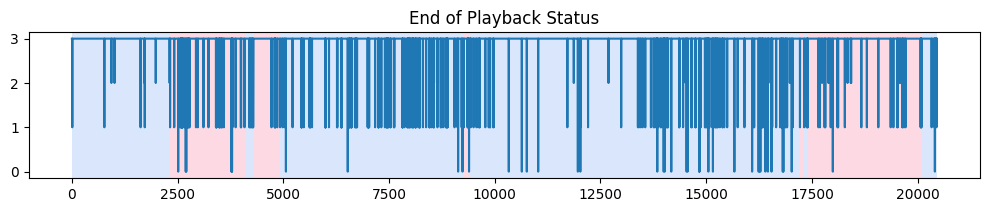

Change points for User_ID_N: [4375, 4480, 4595, 6295, 7275, 8400, 8710, 9965, 10065, 10075, 11940, 16020, 16345, 17315, 20452]


<Figure size 1000x600 with 0 Axes>

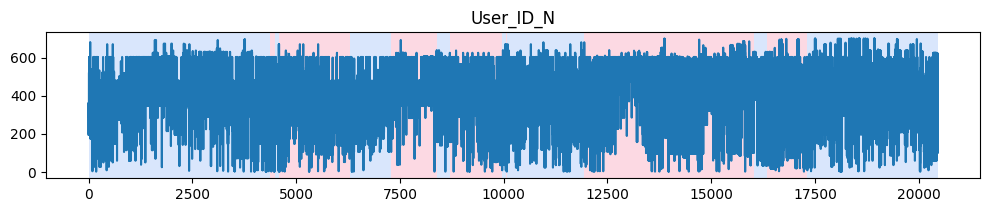

Change points for Title_N: [1255, 4290, 7795, 7830, 7990, 8215, 8305, 8590, 12390, 14500, 14525, 17570, 19785, 19900, 20452]


<Figure size 1000x600 with 0 Axes>

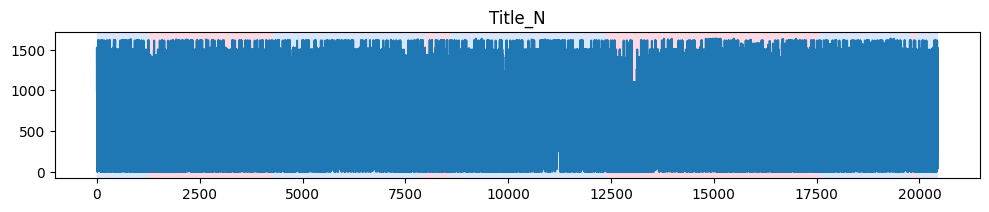

Change points for Device_Vendor_N: [3410, 3570, 3780, 5370, 8340, 9165, 13445, 14015, 16410, 17695, 18955, 18990, 19380, 19520, 20452]


<Figure size 1000x600 with 0 Axes>

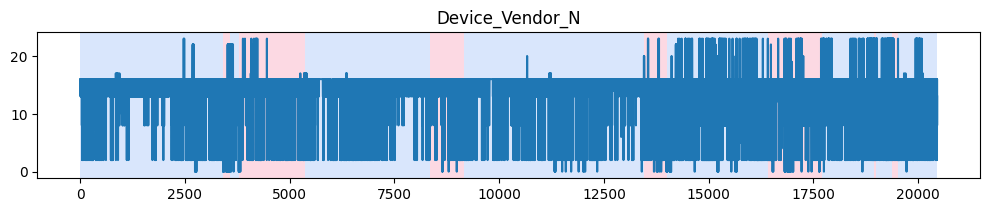

Change points for Device_Model_N: [1845, 5370, 5915, 12205, 13485, 14245, 14670, 14850, 14865, 15360, 16895, 17065, 17260, 18280, 20452]


<Figure size 1000x600 with 0 Axes>

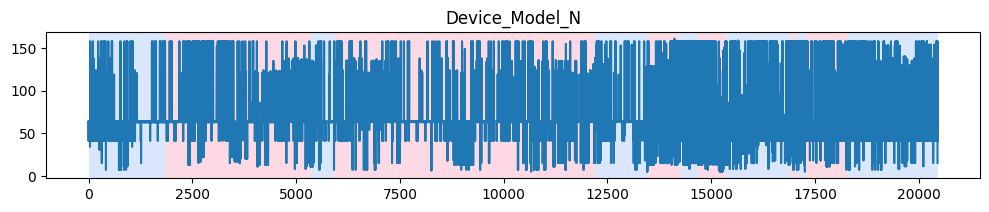

Change points for Content_TV_Show_N: [1845, 3410, 3780, 5570, 13545, 14855, 15025, 15700, 15905, 16500, 16530, 17175, 18280, 19530, 20452]


<Figure size 1000x600 with 0 Axes>

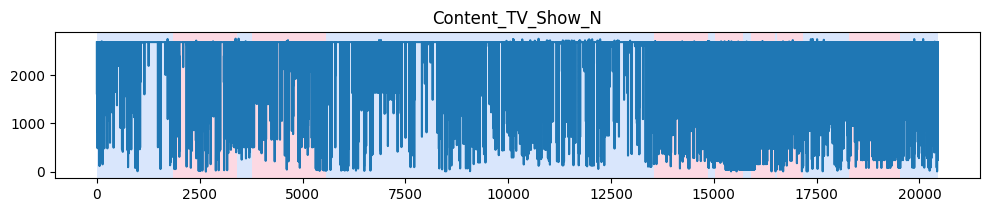

Change points for Country_N: [45, 5320, 5370, 5480, 5595, 6275, 6330, 7100, 7275, 8340, 19885, 19980, 20230, 20365, 20452]


<Figure size 1000x600 with 0 Axes>

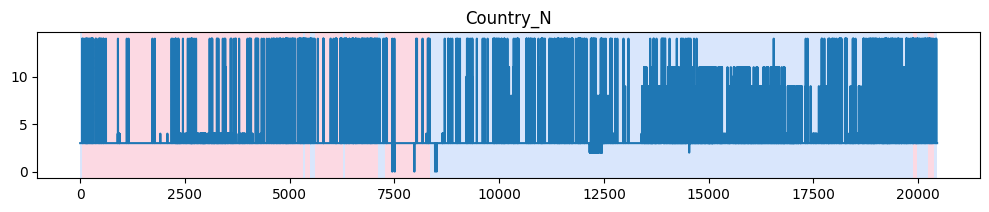

Change points for City_N: [45, 370, 470, 1625, 6275, 6360, 8470, 9975, 10335, 13755, 15965, 18695, 18955, 19885, 20452]


<Figure size 1000x600 with 0 Axes>

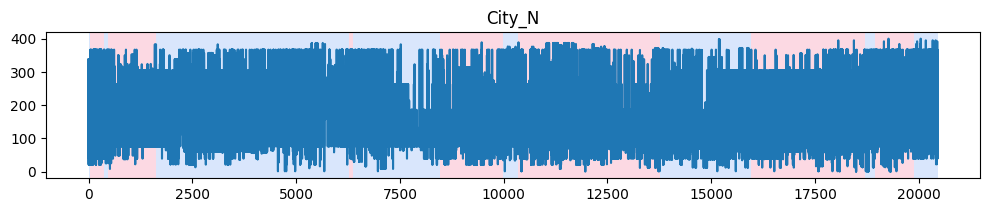

Change points for Region_N: [45, 5320, 5370, 5480, 5595, 6275, 6330, 7100, 7275, 8340, 17695, 19885, 20230, 20365, 20452]


<Figure size 1000x600 with 0 Axes>

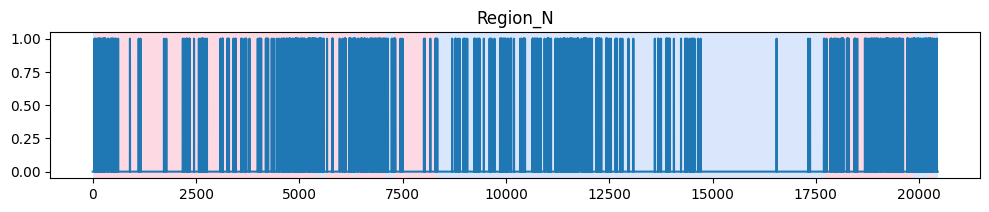

In [31]:
import ruptures as rpt

for column in df.columns:
    # Get the data for the current column
    actual_data = test_data[column].values
    forecast_data = forecast_df[column].values

    # Define the model
    model = "l2"  # "l1", "rbf", "linear", "normal", "ar"

    # Define the window width
    width = 7

    # Perform window-based change point detection for actual data
    # algo_actual = rpt.Window(width=width, model=model).fit(actual_data)
    # breakpoints_actual = algo_actual.predict(n_bkps=1)

    # Perform window-based change point detection for forecast data
    algo_forecast = rpt.Window(width=width, model=model).fit(actual_data)
    breakpoints_forecast = algo_forecast.predict(n_bkps=14)

    # Print the change points
    # print(f"Change points for {column} (Actual): {breakpoints_actual}")
    print(f"Change points for {column}: {breakpoints_forecast}")

    # Plotting the signal and change points for actual data
    # plt.figure(figsize=(10,6))
    # rpt.display(actual_data, breakpoints_actual)
    # plt.title(f'{column} - Actual data')
    # plt.show()

    # Plotting the signal and change points for forecast data
    plt.figure(figsize=(10,6))
    rpt.display(actual_data, breakpoints_forecast)
    plt.title(f'{column}')
    plt.show()


Change points for Playtime: [30, 720, 795, 20452]


<Figure size 1000x600 with 0 Axes>

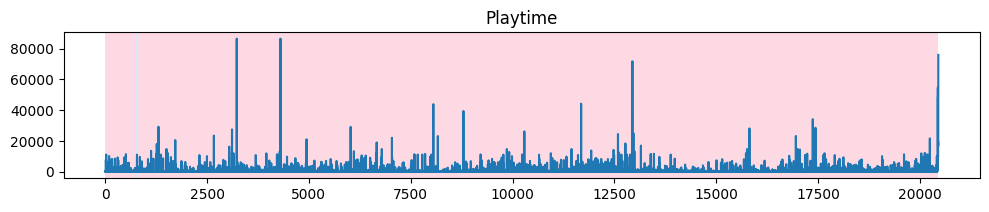

Change points for Interruptions: [30, 690, 790, 20452]


<Figure size 1000x600 with 0 Axes>

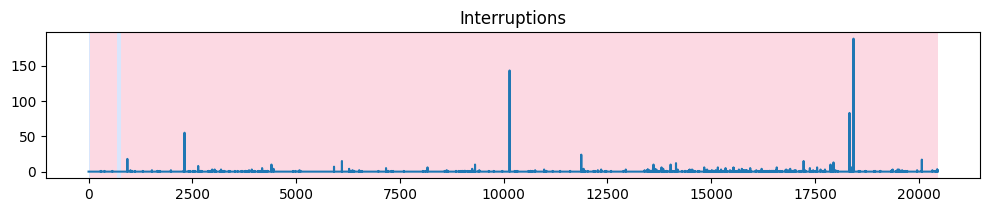

Change points for Join Time: [30, 20452]


<Figure size 1000x600 with 0 Axes>

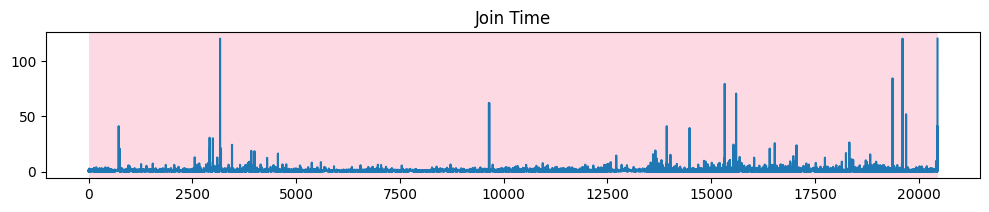

Change points for Buffer Ratio: [30, 765, 20452]


<Figure size 1000x600 with 0 Axes>

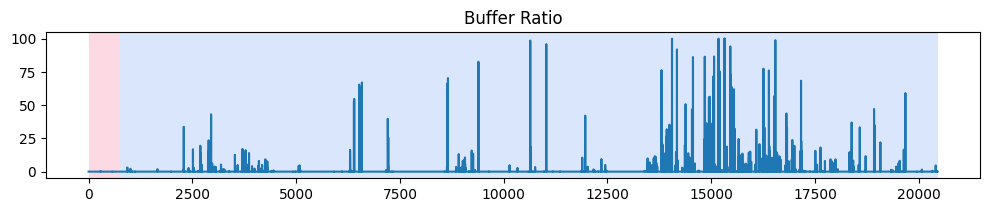

Change points for Connection Type: [30, 695, 20452]


<Figure size 1000x600 with 0 Axes>

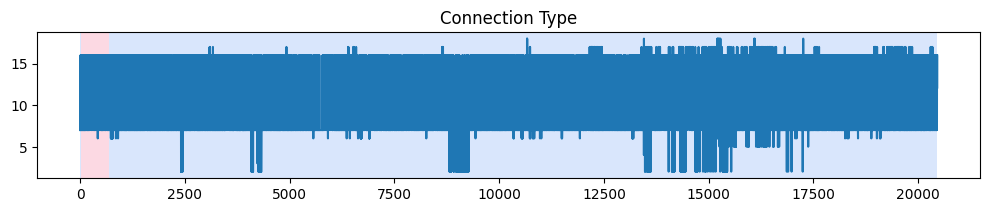

Change points for Device: [30, 20452]


<Figure size 1000x600 with 0 Axes>

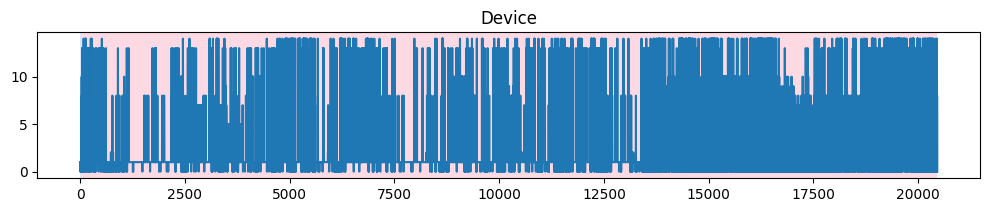

Change points for Device Type: [30, 20452]


<Figure size 1000x600 with 0 Axes>

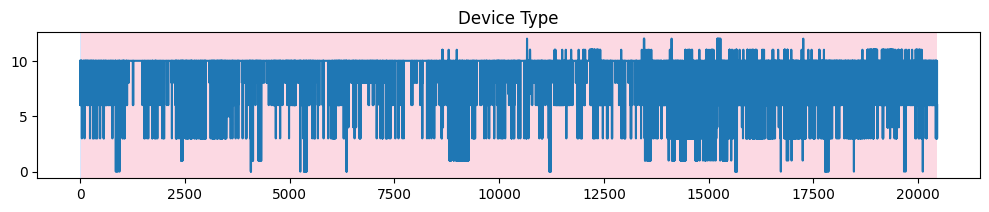

Change points for Browser: [30, 775, 20452]


<Figure size 1000x600 with 0 Axes>

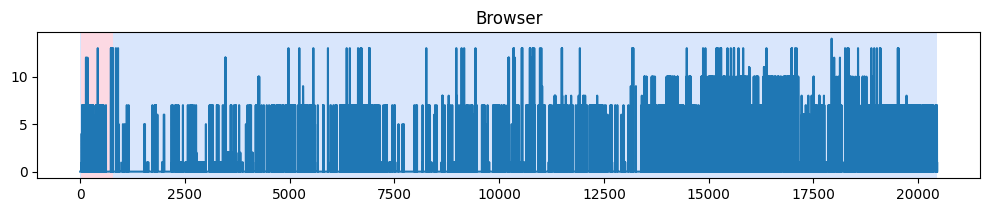

Change points for OS: [30, 770, 20452]


<Figure size 1000x600 with 0 Axes>

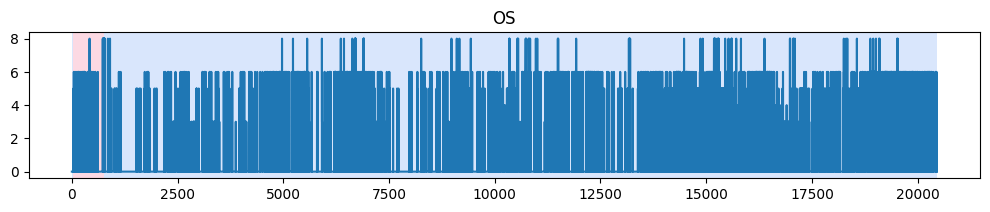

Change points for OS Version: [30, 765, 20452]


<Figure size 1000x600 with 0 Axes>

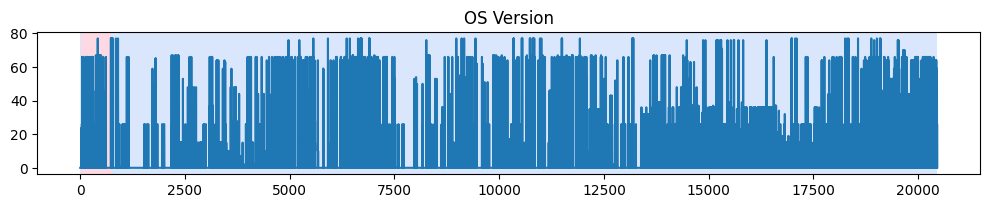

Change points for Device ID: [30, 20452]


<Figure size 1000x600 with 0 Axes>

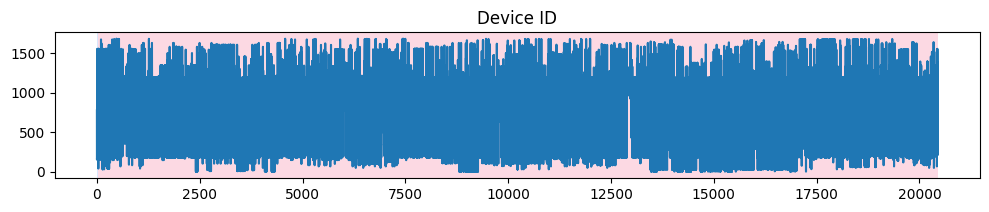

Change points for Happiness Score: [30, 745, 20452]


<Figure size 1000x600 with 0 Axes>

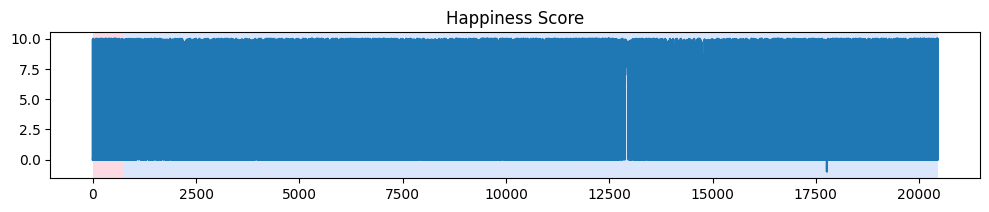

Change points for Playback Stalls: [30, 760, 20452]


<Figure size 1000x600 with 0 Axes>

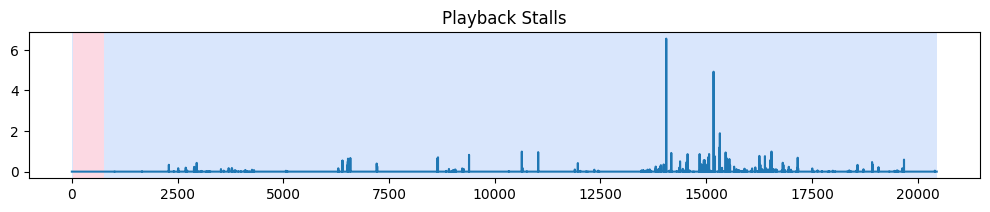

Change points for Startup Error (Count): [30, 765, 20452]


<Figure size 1000x600 with 0 Axes>

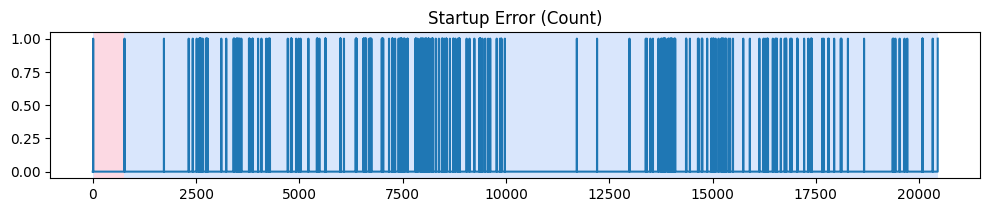

Change points for Latency: [30, 20452]


<Figure size 1000x600 with 0 Axes>

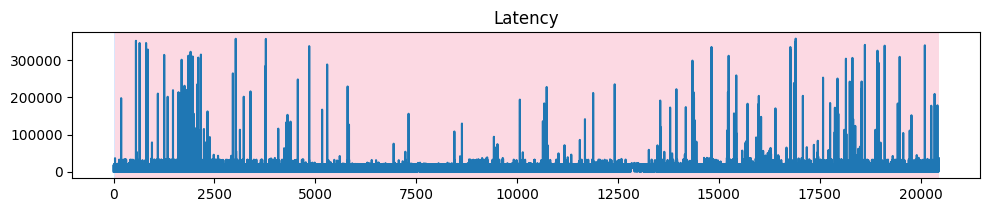

Change points for Crash Status: [40, 760, 20452]


<Figure size 1000x600 with 0 Axes>

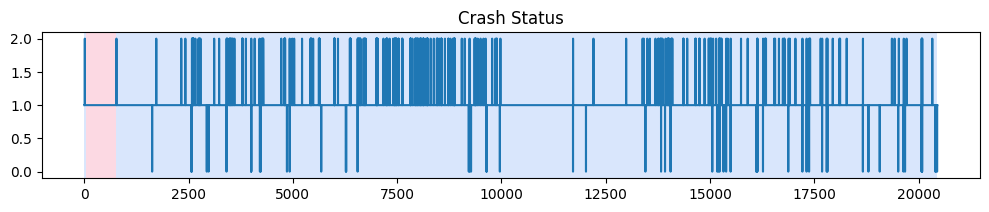

Change points for End of Playback Status: [30, 20452]


<Figure size 1000x600 with 0 Axes>

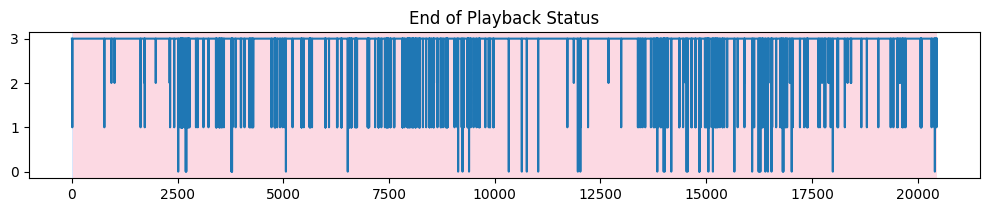

Change points for User_ID_N: [30, 20452]


<Figure size 1000x600 with 0 Axes>

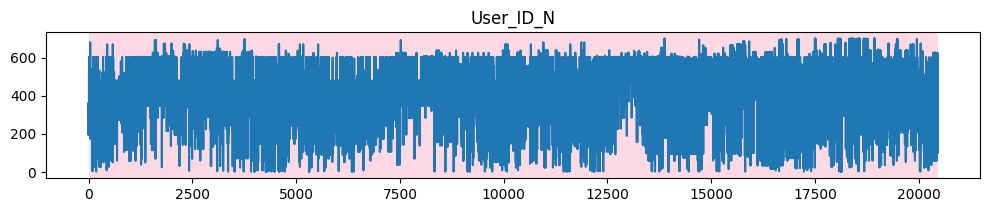

Change points for Title_N: [30, 20452]


<Figure size 1000x600 with 0 Axes>

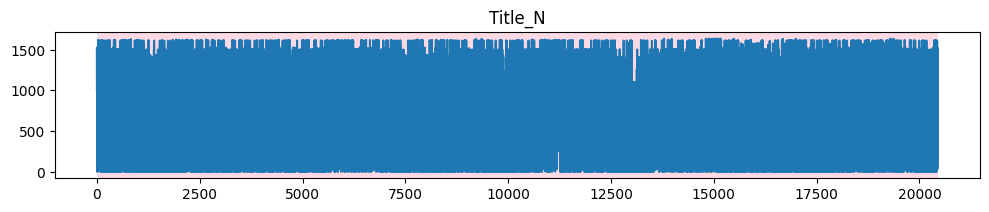

Change points for Device_Vendor_N: [30, 730, 20452]


<Figure size 1000x600 with 0 Axes>

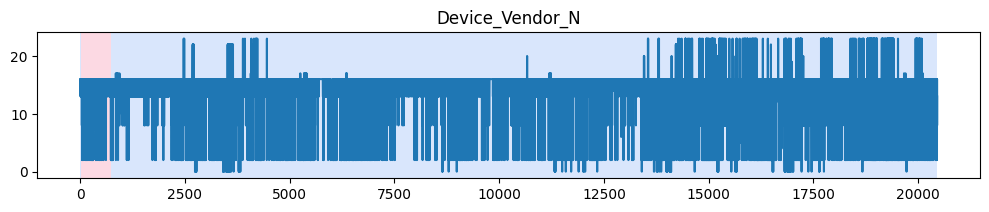

Change points for Device_Model_N: [30, 720, 20452]


<Figure size 1000x600 with 0 Axes>

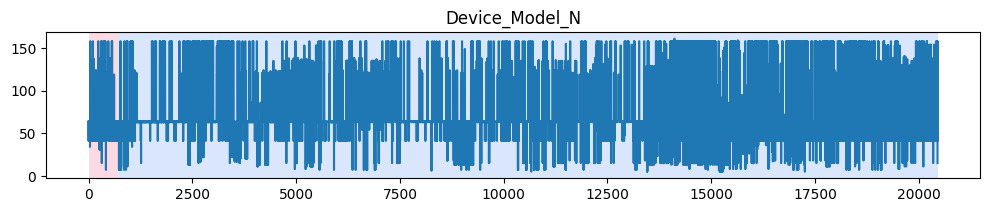

Change points for Content_TV_Show_N: [30, 20452]


<Figure size 1000x600 with 0 Axes>

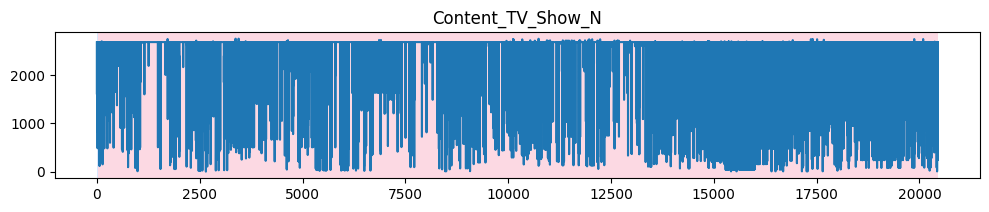

Change points for Country_N: [30, 20452]


<Figure size 1000x600 with 0 Axes>

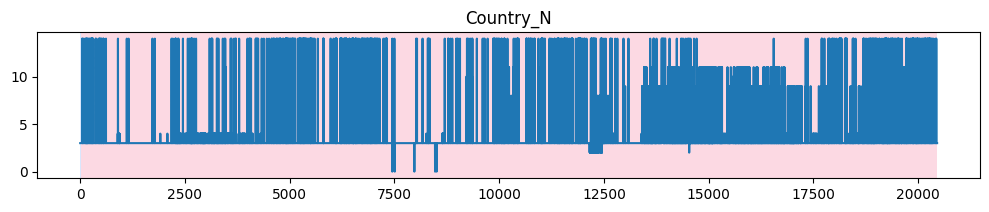

Change points for City_N: [30, 810, 20452]


<Figure size 1000x600 with 0 Axes>

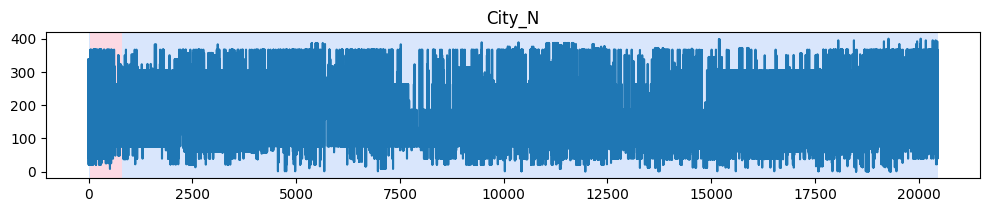

Change points for Region_N: [40, 775, 20452]


<Figure size 1000x600 with 0 Axes>

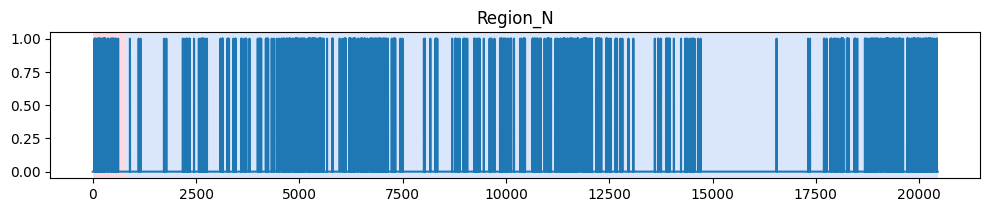

In [30]:
import ruptures as rpt

for column in df.columns:
    # Get the data for the current column
    actual_data = test_data[column].values
    forecast_data = forecast_df[column].values

    # Define the model
    model = "l2"  # "l1", "rbf", "linear", "normal", "ar"

    # Define the window width
    width = 7

    # Perform window-based change point detection for actual data
    # algo_actual = rpt.Window(width=width, model=model).fit(actual_data)
    # breakpoints_actual = algo_actual.predict(n_bkps=1)

    # Perform window-based change point detection for forecast data
    algo_forecast = rpt.Window(width=width, model=model).fit(forecast_data)
    breakpoints_forecast = algo_forecast.predict(n_bkps=14)

    # Print the change points
    # print(f"Change points for {column} (Actual): {breakpoints_actual}")
    print(f"Change points for {column}: {breakpoints_forecast}")

    # Plotting the signal and change points for actual data
    # plt.figure(figsize=(10,6))
    # rpt.display(actual_data, breakpoints_actual)
    # plt.title(f'{column} - Actual data')
    # plt.show()

    # Plotting the signal and change points for forecast data
    plt.figure(figsize=(10,6))
    rpt.display(actual_data, breakpoints_forecast)
    plt.title(f'{column}')
    plt.show()


From the result it shows that this model have good result for the actual data from test set but not have good result for the forecast data. It happend caused by residual interfering forecast result. And like on the CUSUM, Window-Based method also shows change detected on almost every time window.

This two result shows that residual cause the forecast have bad result and affect detecting change on the forecast.

but, CUSUM shows better performance since it can detected changes for evey data point drifted. 

From all of the result, it shows bad latency causes users to stop playing the video. This event causes residual in the data and thus, spread residual data to every features. From change detection it also shows this residual appear almost every time which shows there is problem with latency in the network. 